# Evaluation

## Footnote

While this is __almost__ identical to `result_per_episode_plot_20250922.ipynb`, the only difference is 

```python
expt_train_selectedckpt_folder = expt_folder / ("logs_" + 'train' + '_selected-ckpt')

expt_phrase_folder = expt_train_selectedckpt_folder
```

This is due to a request that we need specific analysis on a specific RL model checkpoint during training (e.g. the model after iteration 600). Previously, RL model evaluation is based on the last executed checkpoint.

Therefore, this notebook is duplicated from `results_per_episode_plot.ipynb` with the aforementioned snippet added.

## How to use

To use this nodebook, select an experiment under the `experiments/` folder. Then create a folder namely `selected_ckpt`. Then select a checkpoint, and copy the `episode_0xxx` folder under `experiments/<your_selected_expt>/selected_ckpt` folder.

Then run either `rl_training_eval_<DDQN|PPO>.ipynb` depending your model. It will produce the result of applying the selected checkpoint to every training episodes under `logs_train_selected-ckpt`.

Then modify the corresponding variable to point to your selected experiment folder, then analyze the result of the model under training dataset.

---

## Per-Episode Plotting Functions

This notebook contains all functions that produce plots related to each training episode, including:
- User load vs grid load vs battery SOC plots
- Reward components over time (f_signal, g_signal)
- H-network loss analysis plots
- Power signal density + mutual information analysis
- Episode overview and detailed analysis

These functions are extracted and organized from various experiment analysis notebooks for easy reuse and consistent per-episode analysis.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter
from sklearn.feature_selection import mutual_info_regression
import matplotlib.mlab as mlab
import torch
import torch.nn as nn

# Use non-interactive backend for matplotlib to save memory
matplotlib.use('Agg')

from utils import print_log

## Experiment Configuration

Configure the experiment folder and load necessary data for per-episode plotting analysis.

This script should work with logs_train and logs_test. For logs_validation, please go to a different script

In [2]:
# Configure experiment folder
# expt_datetime = datetime(2025, 8, 11, 2, 46, 31)  # Modify this to your experiment
expt_datetime = datetime(2025, 8, 11, 4, 45, 55)  # Modify this to your experiment
# expt_datetime = datetime(2025, 8, 11, 6, 42, 39)  # Modify this to your experiment

# expt_datetime = datetime(2025, 8, 13, 23, 23, 31)  # Modify this to your experiment
# expt_datetime = datetime(2025, 8, 14, 2, 5, 26)  # Modify this to your experiment
# expt_datetime = datetime(2025, 8, 14, 4, 46, 19)  # Modify this to your experiment


action_type = "continuous"  # Modify this to your action type ("continuous" or "discrete")
reward_lambda = "0.5"  # Modify this to your reward lambda


# Alternative: Use experiment with action type and reward lambda in folder name
expt_folder = Path("experiments") \
    / (expt_datetime.strftime("%Y%m%d_%H%M%S") + "_action_" + action_type + "_reward_lambda_" + reward_lambda) \

if not expt_folder.exists():
    print_log(f"Experiment folder {expt_folder} does not exist. Please check the path.")
else:
    print_log(f"Using experiment folder: {expt_folder}")

expt_train_folder = expt_folder / ("logs_" + 'train')
expt_valid_folder = expt_folder / ("logs_" + "validation")
if action_type == "continuous":
    expt_test_folder = expt_folder / ("logs_" + "test") / "episode_0703"    # continuous case
elif action_type == "discrete":
    expt_test_folder = expt_folder / ("logs_" + "test") / "episode_0700"    # discrete case
expt_train_selectedckpt_folder = expt_folder / ("logs_" + 'train' + '_selected-ckpt')

expt_phrase_folder = expt_train_selectedckpt_folder


if not expt_train_folder.exists():
    print_log(f"Training logs folder {expt_train_folder} does not exist. Please check the path.")

[2025-09-24 21:44:25:777] Using experiment folder: experiments/20250811_044555_action_continuous_reward_lambda_0.5


In [3]:
# only discrete will be used: load the step size in the household load

if action_type == 'discrete':

    expt_details_path = expt_folder / "experiment_details.json"

    with open(expt_details_path) as f:
        expt_details = json.load(f)

    AGGREGATE_STEP_SIZE = expt_details["aggregate_step_size"]

In [4]:
# Load episode information data
episode_info_folder = expt_phrase_folder / "episode_info"
if episode_info_folder.exists():
    episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
    episode_info_dfs = []
    episode_metadata_list = []

    print_log(f"Loading {len(episode_info_files)} episode files...")
    
    # Helper function to flatten nested dictionaries
    def flatten(d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.extend(flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    for file in episode_info_files:
        with open(file, "r") as f:
            episode_info = json.load(f)
            
            # Extract episode data and metadata (support new format)
            if isinstance(episode_info, dict) and 'episode_data' in episode_info:
                # New format with metadata
                episode_data = episode_info['episode_data']
                metadata = episode_info.get('metadata', {})
                df = pd.DataFrame(episode_data)

                metadata = flatten(metadata)  # Flatten metadata dictionary
                
                # Store metadata for analysis
                episode_metadata_list.append({
                    'episode_file': file.name,
                    **metadata
                })
            else:
                # Legacy format - just episode data
                df = pd.DataFrame(episode_info)
                episode_metadata_list.append({
                    'episode_file': file.name,
                    'episode_idx': int(file.stem.split('_')[1]),
                    'episode_content_id': None,
                    'episode_length_days': 1,  # Default to 1 day for legacy
                    'curriculum_phase': None,
                    'data_loader_type': 'Unknown'
                })

            # Add episode number column
            df['episode'] = int(file.stem.split('_')[1])
            df['episode_index'] = len(episode_info_dfs)                     # Add episode index for plotting
            df['episode_data_idx'] = metadata.get('episode_data_idx', 0)    # Add episode data index
            
            # Convert datetime strings to datetime objects
            if 'datetime' in df.columns:
                df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')
            
            # Temporary fix: shift some columns forward by one timestep
            shift_columns = ['grid_load (W)', 'action (kW)', 'battery_action (kW)', 'reward', 
                           'f_signal', 'g_signal', 'f_signal-predicted_mean', 
                           'f_signal-predicted_log_var', 'f_signal-target', 'f_signal-loss']
            
            for col in shift_columns:
                if col in df.columns:
                    df[col] = df[col].shift(-1)
            
            # Remove the last row for each episode
            df = df[:-1]

            # temporary fix for grid load calculation (once)
            df['grid_load (W)'] = df['user_load (W)'] + df['battery_action (kW)'] * 1000
            
            episode_info_dfs.append(df)

    # Create episode metadata DataFrame for curriculum analysis
    episode_metadata_df = pd.DataFrame(episode_metadata_list)
    
    print_log(f"Loaded {len(episode_info_dfs)} episodes")
    print_log(f"Episode metadata shape: {episode_metadata_df.shape}")
    
else:
    print_log(f"Episode info folder {episode_info_folder} does not exist.")
    episode_info_dfs = None
    episode_metadata_df = None

[2025-09-24 21:44:26:703] Loading 162 episode files...
[2025-09-24 21:44:27:974] Loaded 162 episodes
[2025-09-24 21:44:27:975] Episode metadata shape: (162, 9)


In [5]:
# Concatenate all episode DataFrames and display summary statistics
if episode_info_dfs is not None and len(episode_info_dfs) > 0:
    # Concatenate all DataFrames into one for overall analysis
    episode_info_df = pd.concat(episode_info_dfs, ignore_index=True)
    
    print_log(f"Combined dataset shape: {episode_info_df.shape}")
    print_log(f"Available columns: {list(episode_info_df.columns)}")
    
    # Display episode metadata summary
    if episode_metadata_df is not None:
        print_log("Episode Metadata Summary:")
        if 'episode_length_days' in episode_metadata_df.columns:
            print_log(f"  Episode lengths (days): {episode_metadata_df['episode_length_days'].describe()}")
        if 'curriculum_phase' in episode_metadata_df.columns:
            phase_counts = episode_metadata_df['curriculum_phase'].value_counts()
            print_log(f"  Curriculum phases: {dict(phase_counts)}")
    
    # Display sample of first episode data
    display(episode_info_df)
    
else:
    print_log("No episode data available - will use sample data for demonstrations")

[2025-09-24 21:44:28:669] Combined dataset shape: (231389, 17)
[2025-09-24 21:44:28:669] Available columns: ['episode_index', 'current_step', 'datetime', 'battery_soc (%)', 'battery_soc (kWh)', 'user_load (W)', 'grid_load (W)', 'action (kW)', 'battery_action (kW)', 'reward', 'f_signal', 'g_signal', 'f_signal-predicted_mean', 'f_signal-predicted_log_var', 'f_signal-target', 'episode', 'episode_data_idx']
[2025-09-24 21:44:28:669] Episode Metadata Summary:
[2025-09-24 21:44:28:671]   Episode lengths (days): count    162.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: episode_length_days, dtype: float64


,episode_index,current_step,datetime,battery_soc (%),battery_soc (kWh),user_load (W),grid_load (W),action (kW),battery_action (kW),reward,f_signal,g_signal,f_signal-predicted_mean,f_signal-predicted_log_var,f_signal-target,episode,episode_data_idx
0,0,0,2013-01-08 00:00:05,0.150000,1.200000,234.000000,701.373669,0.467374,0.467374,0.177405,-0.356165,0.001355,0.761523,0.0,-0.476774,0,0
1,0,1,2013-01-08 00:01:05,0.150974,1.207790,230.407069,655.817042,0.425410,0.425410,0.157862,-0.316987,0.001263,0.571403,0.0,-0.476174,0,0
2,0,2,2013-01-08 00:02:05,0.151860,1.214880,230.680121,153.052433,-0.077628,-0.077628,0.020491,-0.041481,0.000499,-0.179799,0.0,-0.474135,0,0
3,0,3,2013-01-08 00:03:05,0.151698,1.213586,231.607379,17.404110,-0.214203,-0.214203,0.001447,-0.003693,0.000799,-0.388753,0.0,-0.474854,0,0
4,0,4,2013-01-08 00:04:05,0.151252,1.210016,231.280688,0.000000,-0.650695,-0.231281,0.000169,-0.001174,0.000836,-0.429096,0.0,-0.477583,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231384,161,1434,2013-12-28 23:54:03,1.000000,8.000000,280.411339,280.411339,1.086295,0.000000,0.020481,-0.041291,0.000329,0.091489,0.0,-0.202144,161,161
231385,161,1435,2013-12-28 23:55:03,1.000000,8.000000,279.137321,9.079166,-0.270058,-0.270058,-0.000853,-0.000008,0.001713,-0.286243,0.0,-0.290147,161,161
231386,161,1436,2013-12-28 23:56:03,0.999437,7.995499,239.057044,282.349865,0.043293,0.043293,0.044729,-0.090008,0.000551,0.109565,0.0,-0.336341,161,161
231387,161,1437,2013-12-28 23:57:03,0.999528,7.996221,218.018093,444.783427,0.279707,0.226765,0.087132,-0.175754,0.001491,0.324211,0.0,-0.337187,161,161


In [6]:
episode_metadata_df

,episode_file,episode_data_idx,episode_content_id,episode_length_days,training_timestep,dataset_type,curriculum_info_curriculum_enabled,timestamp_created,episode_training_idx
0,episode_0000_info.json,0,1e8894d05c89,1,0,test,False,2025-09-23T16:10:35.709342,0
1,episode_0001_info.json,1,0a3457ad5563,1,0,test,False,2025-09-23T16:10:41.464427,1
2,episode_0002_info.json,2,5930d55d98d0,1,0,test,False,2025-09-23T16:10:43.634102,2
3,episode_0003_info.json,3,d5505ebe6bce,1,0,test,False,2025-09-23T16:10:50.860603,3
4,episode_0004_info.json,4,c1ef35814bd7,1,0,test,False,2025-09-23T16:10:56.763535,4
...,...,...,...,...,...,...,...,...,...
157,episode_0157_info.json,157,d43e391cf44c,1,0,test,False,2025-09-23T16:26:24.694354,157
158,episode_0158_info.json,158,4689a3c22411,1,0,test,False,2025-09-23T16:26:31.818884,158
159,episode_0159_info.json,159,0e3940e6e8f7,1,0,test,False,2025-09-23T16:26:37.635498,159
160,episode_0160_info.json,160,252649594d68,1,0,test,False,2025-09-23T16:26:43.639215,160


## Basic Episode Plotting Functions

Functions to plot individual episode details including user load, grid load, and battery SOC with proper aesthetics from the original `plot_episode_details` function.

In [7]:
def plot_episode_details(episode_df, save_path=None, use_datetime=False, show=True):
    """
    Plot episode details with user load, grid load, and battery SOC using original aesthetics.
    
    Args:
        episode_df: DataFrame containing episode information
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True, dpi=150)
    
    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else 0
    episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else 0
    # First subplot: User load with original aesthetics
    # Original aesthetics from plot_episode_details in expt_results.ipynb:
    # User Load: color='blue', linewidth=2
    ax1.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2)

    ax1.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: User Load Over Time')
    ax1.set_ylabel('Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)


    # Second subplot: Grid load with original aesthetics
    # Grid Load: color='orange', linewidth=2, alpha=0.7 (no need for alpha as they don't overlap)
    ax2.plot(x_values, episode_df['grid_load (W)'], label='Grid Load (Masked)', color='orange', linewidth=2)
    ax2.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: Grid Load Over Time')
    ax2.set_ylabel('Power (W)')
    ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Third subplot: Battery SOC with color coding using LineCollection
    soc_values = episode_df['battery_soc (kWh)'].values

    # Calculate SOC changes
    soc_changes = np.diff(soc_values)
    
    # Create numerical color array based on SOC changes for smooth coloring
    # -1: red (decreasing), 0: blue (no change), 1: green (increasing)
    color_values = []
    for change in soc_changes:
        if change > 1e-6:  # Small threshold to handle floating point precision
            color_values.append(1)  # Green for increasing
        elif change < -1e-6:
            color_values.append(-1)  # Red for decreasing
        else:
            color_values.append(0)  # Blue for no change
    
    # Create line segments for color coding
    if use_datetime and 'datetime' in episode_df.columns:
        # Convert datetime to matplotlib date numbers for LineCollection
        from matplotlib.dates import date2num
        x_numeric = date2num(episode_df['datetime'])
    else:
        x_numeric = np.array(range(len(episode_df)))
    
    # Create line segments
    points = np.array([x_numeric, soc_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create LineCollection with colors
    lc = LineCollection(segments, linewidths=2, capstyle='round')
    lc.set_array(np.array(color_values))  # Set color values for segments

    # Create custom colormap: red (-1) -> blue (0) -> green (1)
    colors_map = ['red', 'blue', 'green']
    cmap = ListedColormap(colors_map, name='soc_change', N=3)

    lc.set_cmap(cmap)
    lc.set_clim(-1, 1)

    line = ax3.add_collection(lc)

    ax3.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: Battery State of Charge Over Time')
    ax3.set_xlabel(x_label)
    ax3.set_ylabel('SOC (kWh)')
    ax3.grid(True, alpha=0.3)
    
    # Set axis limits for better visualization
    if use_datetime and 'datetime' in episode_df.columns:
        ax3.set_xlim(episode_df['datetime'].iloc[0], episode_df['datetime'].iloc[-1])
    else:
        ax3.set_xlim(0, len(episode_df)-1)
    ax3.set_ylim(soc_values.min() * 0.95, soc_values.max() * 1.05)

    # Add legend for SOC colors
    legend_elements = [Patch(facecolor='green', label='SOC Increasing'),
                      Patch(facecolor='red', label='SOC Decreasing'),
                      Patch(facecolor='blue', label='SOC No Change')]
    ax3.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        formatter = DateFormatter('%H:%M:%S')
        for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close(fig)
        plt.close('all')
    return fig

[2025-09-23 13:02:34:993] Plotting basic episode details for episode 0010...


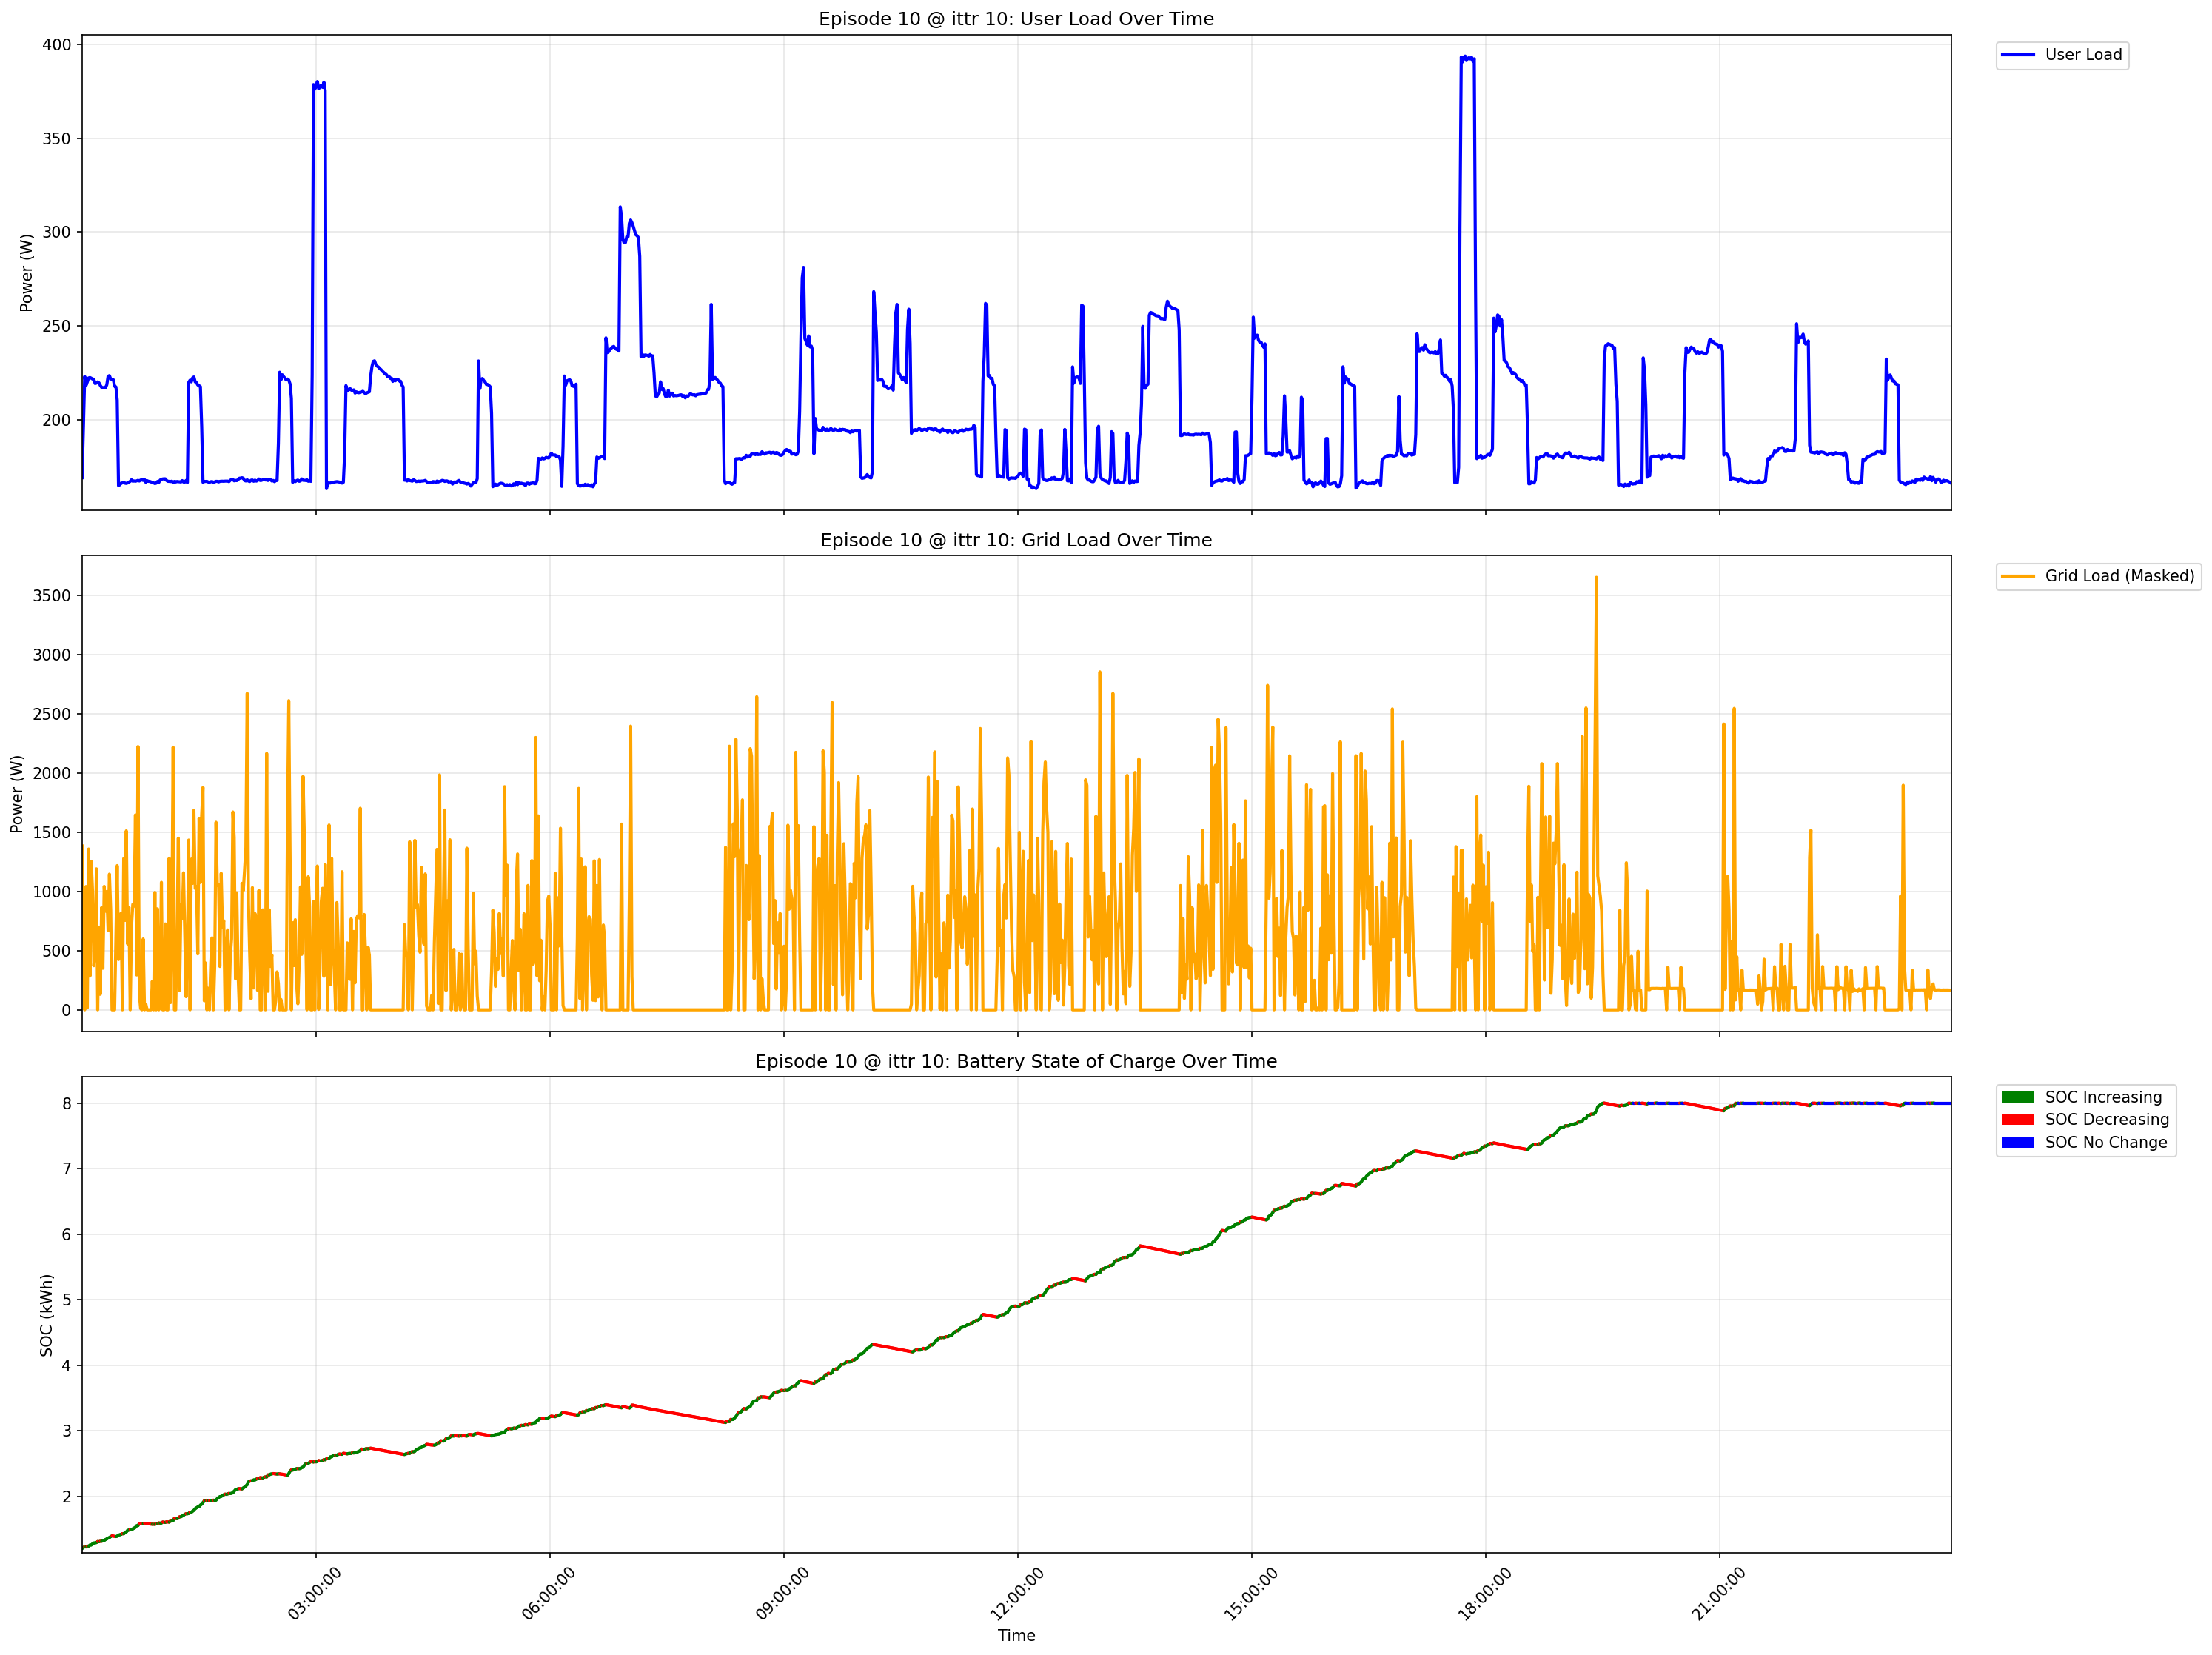

[2025-09-23 13:02:35:468] Episode details plot saved to: experiments/20250811_044555_action_continuous_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode/episode_0010_details.png


In [ ]:
# Example usage: Plot basic episode details for first episode
# uncomment the following lines to run the example

# if episode_info_dfs is not None and len(episode_info_dfs) > 0:
#     # Select an episode for demonstration
#     sample_episode = episode_info_dfs[10]
#     episode = sample_episode['episode'].iloc[0] if 'episode' in sample_episode.columns else 0

#     print_log(f"Plotting basic episode details for episode {episode:04d}...")

#     # Create save path
#     save_path = expt_phrase_folder / "graphs" / "per_episode" / f"episode_{episode:04d}_details.png"
#     if not save_path.parent.exists():
#         save_path.parent.mkdir(parents=True, exist_ok=True)
    
#     # Plot episode details
#     fig = plot_episode_details(
#         sample_episode,
#         save_path=None,
#         use_datetime=True, 
#         show=True
#     )
#     print_log(f"Episode details plot saved to: {save_path}")
    
# else:
#     print_log("No episode data available - creating sample episode details plot...")
    
#     # Create sample episode data for demonstration
#     time_steps = 144  # 24 hours * 6 (10-minute intervals)
#     sample_episode_df = pd.DataFrame({
#         'datetime': pd.date_range('2025-01-01 00:00:00', periods=time_steps, freq='10T'),
#         'user_load (W)': 2000 + 1000 * np.sin(np.linspace(0, 4*np.pi, time_steps)) + 200 * np.random.random(time_steps),
#         'grid_load (W)': 1800 + 800 * np.sin(np.linspace(0.5, 4.5*np.pi, time_steps)) + 150 * np.random.random(time_steps),
#         'battery_soc (kWh)': 50 + 20 * np.sin(np.linspace(0, 2*np.pi, time_steps)) + 2 * np.random.random(time_steps),
#         'episode_index': [0] * time_steps
#     })
    
#     fig = plot_episode_details(sample_episode_df, 0, use_datetime=True, show=True)

In [8]:
for episode_df in episode_info_dfs:

    episode = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else 0

    print_log(f"Plotting basic episode details for episode {episode:04d}...")

    # Create save path
    save_path = expt_phrase_folder / "graphs" / "per_episode" / f"episode_{episode:04d}_details.svg"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    show=False  # Set to False to avoid displaying during batch processing
    
    # Plot episode details
    fig = plot_episode_details(
        episode_df,
        save_path=save_path,
        use_datetime=True, 
        show=show
    )

    if not show:
        del fig

    print_log(f"Episode details plot saved to: {save_path}")

[2025-09-23 16:54:41:466] Plotting basic episode details for episode 0000...
[2025-09-23 16:54:41:869] Episode details plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode/episode_0000_details.svg
[2025-09-23 16:54:41:869] Plotting basic episode details for episode 0001...
[2025-09-23 16:54:42:165] Episode details plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode/episode_0001_details.svg
[2025-09-23 16:54:42:165] Plotting basic episode details for episode 0002...
[2025-09-23 16:54:42:454] Episode details plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode/episode_0002_details.svg
[2025-09-23 16:54:42:455] Plotting basic episode details for episode 0003...
[2025-09-23 16:54:42:757] Episode details plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_trai

In [9]:
def plot_episode_overview(episode_df, save_path=None, use_datetime=False, show=True):
    """
    Plot episode overview with four subplots: load profiles, battery actions, battery SOC, and H-network signals.
    
    Args:
        episode_df: DataFrame containing episode information
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20), sharex=True, dpi=150)
    
    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else 0
    episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else 0
    
    # First subplot: User load and Grid load with original aesthetics
    ax1.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2)
    ax1.plot(x_values, episode_df['grid_load (W)'], label='Grid Load (Masked)', color='orange', linewidth=2, alpha=0.7)

    ax1.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: Load Profiles Over Time')
    ax1.set_ylabel('Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second subplot: Agent Actions (action and battery_action)
    ax2.plot(x_values, episode_df['action (kW)'], label="Agent's action", color='blue', linewidth=2, alpha=0.7)
    ax2.plot(x_values, episode_df['battery_action (kW)'], label='RB response', color='orange', linewidth=2, alpha=0.7)

    ax2.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: Agent Actions Over Time')
    ax2.set_ylabel('Power (kW)')
    ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Third subplot: Battery SOC with color coding using LineCollection
    soc_values = episode_df['battery_soc (kWh)'].values

    # Calculate SOC changes
    soc_changes = np.diff(soc_values)
    
    # Create numerical color array based on SOC changes for smooth coloring
    # -1: red (decreasing), 0: blue (no change), 1: green (increasing)
    color_values = []
    for change in soc_changes:
        if change > 1e-6:  # Small threshold to handle floating point precision
            color_values.append(1)  # Green for increasing
        elif change < -1e-6:
            color_values.append(-1)  # Red for decreasing
        else:
            color_values.append(0)  # Blue for no change
    
    # Create line segments for color coding
    if use_datetime and 'datetime' in episode_df.columns:
        # Convert datetime to matplotlib date numbers for LineCollection
        from matplotlib.dates import date2num
        x_numeric = date2num(episode_df['datetime'])
    else:
        x_numeric = np.array(range(len(episode_df)))
    
    # Create line segments
    points = np.array([x_numeric, soc_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create LineCollection with colors
    lc = LineCollection(segments, linewidths=2, capstyle='round')
    lc.set_array(np.array(color_values))  # Set color values for segments

    # Create custom colormap: red (-1) -> blue (0) -> green (1)
    colors_map = ['red', 'blue', 'green']
    cmap = ListedColormap(colors_map, name='soc_change', N=3)

    lc.set_cmap(cmap)
    lc.set_clim(-1, 1)

    line = ax3.add_collection(lc)

    ax3.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: Battery State of Charge Over Time')
    ax3.set_ylabel('SOC (kWh)')
    ax3.grid(True, alpha=0.3)
    
    # Set axis limits
    if use_datetime and 'datetime' in episode_df.columns:
        ax3.set_xlim(episode_df['datetime'].iloc[0], episode_df['datetime'].iloc[-1])
    else:
        ax3.set_xlim(0, len(episode_df)-1)
    ax3.set_ylim(soc_values.min() * 0.95, soc_values.max() * 1.05)
    
    # Add legend for SOC colors
    legend_elements = [Patch(facecolor='green', label='SOC Increasing'),
                      Patch(facecolor='red', label='SOC Decreasing'),
                      Patch(facecolor='blue', label='SOC No Change')]
    ax3.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Fourth subplot: H-network output signals (f_signal and g_signal)
    signal_valid_mask = ~(episode_df['f_signal'].isna() | episode_df['g_signal'].isna())
    
    if use_datetime and 'datetime' in episode_df.columns:
        x_signal_valid = episode_df.loc[signal_valid_mask, 'datetime']
    else:
        x_signal_valid = np.array(x_values)[signal_valid_mask]
    
    f_signal = episode_df.loc[signal_valid_mask, 'f_signal']
    g_signal = episode_df.loc[signal_valid_mask, 'g_signal']
    
    ax4.plot(x_signal_valid, f_signal, label='f_signal', color='green', linewidth=2)
    ax4.plot(x_signal_valid, g_signal, label='g_signal', color='purple', linewidth=2)
    
    ax4.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: Reward Components Over Time')
    ax4.set_xlabel(x_label)
    ax4.set_ylabel('Signal Value')
    ax4.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        formatter = DateFormatter('%H:%M:%S')
        for ax in [ax1, ax2, ax3, ax4]:
            ax.xaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close(fig)
        plt.close('all')
    return fig

[2025-09-23 13:02:42:822] Plotting episode overview for episode 0010...


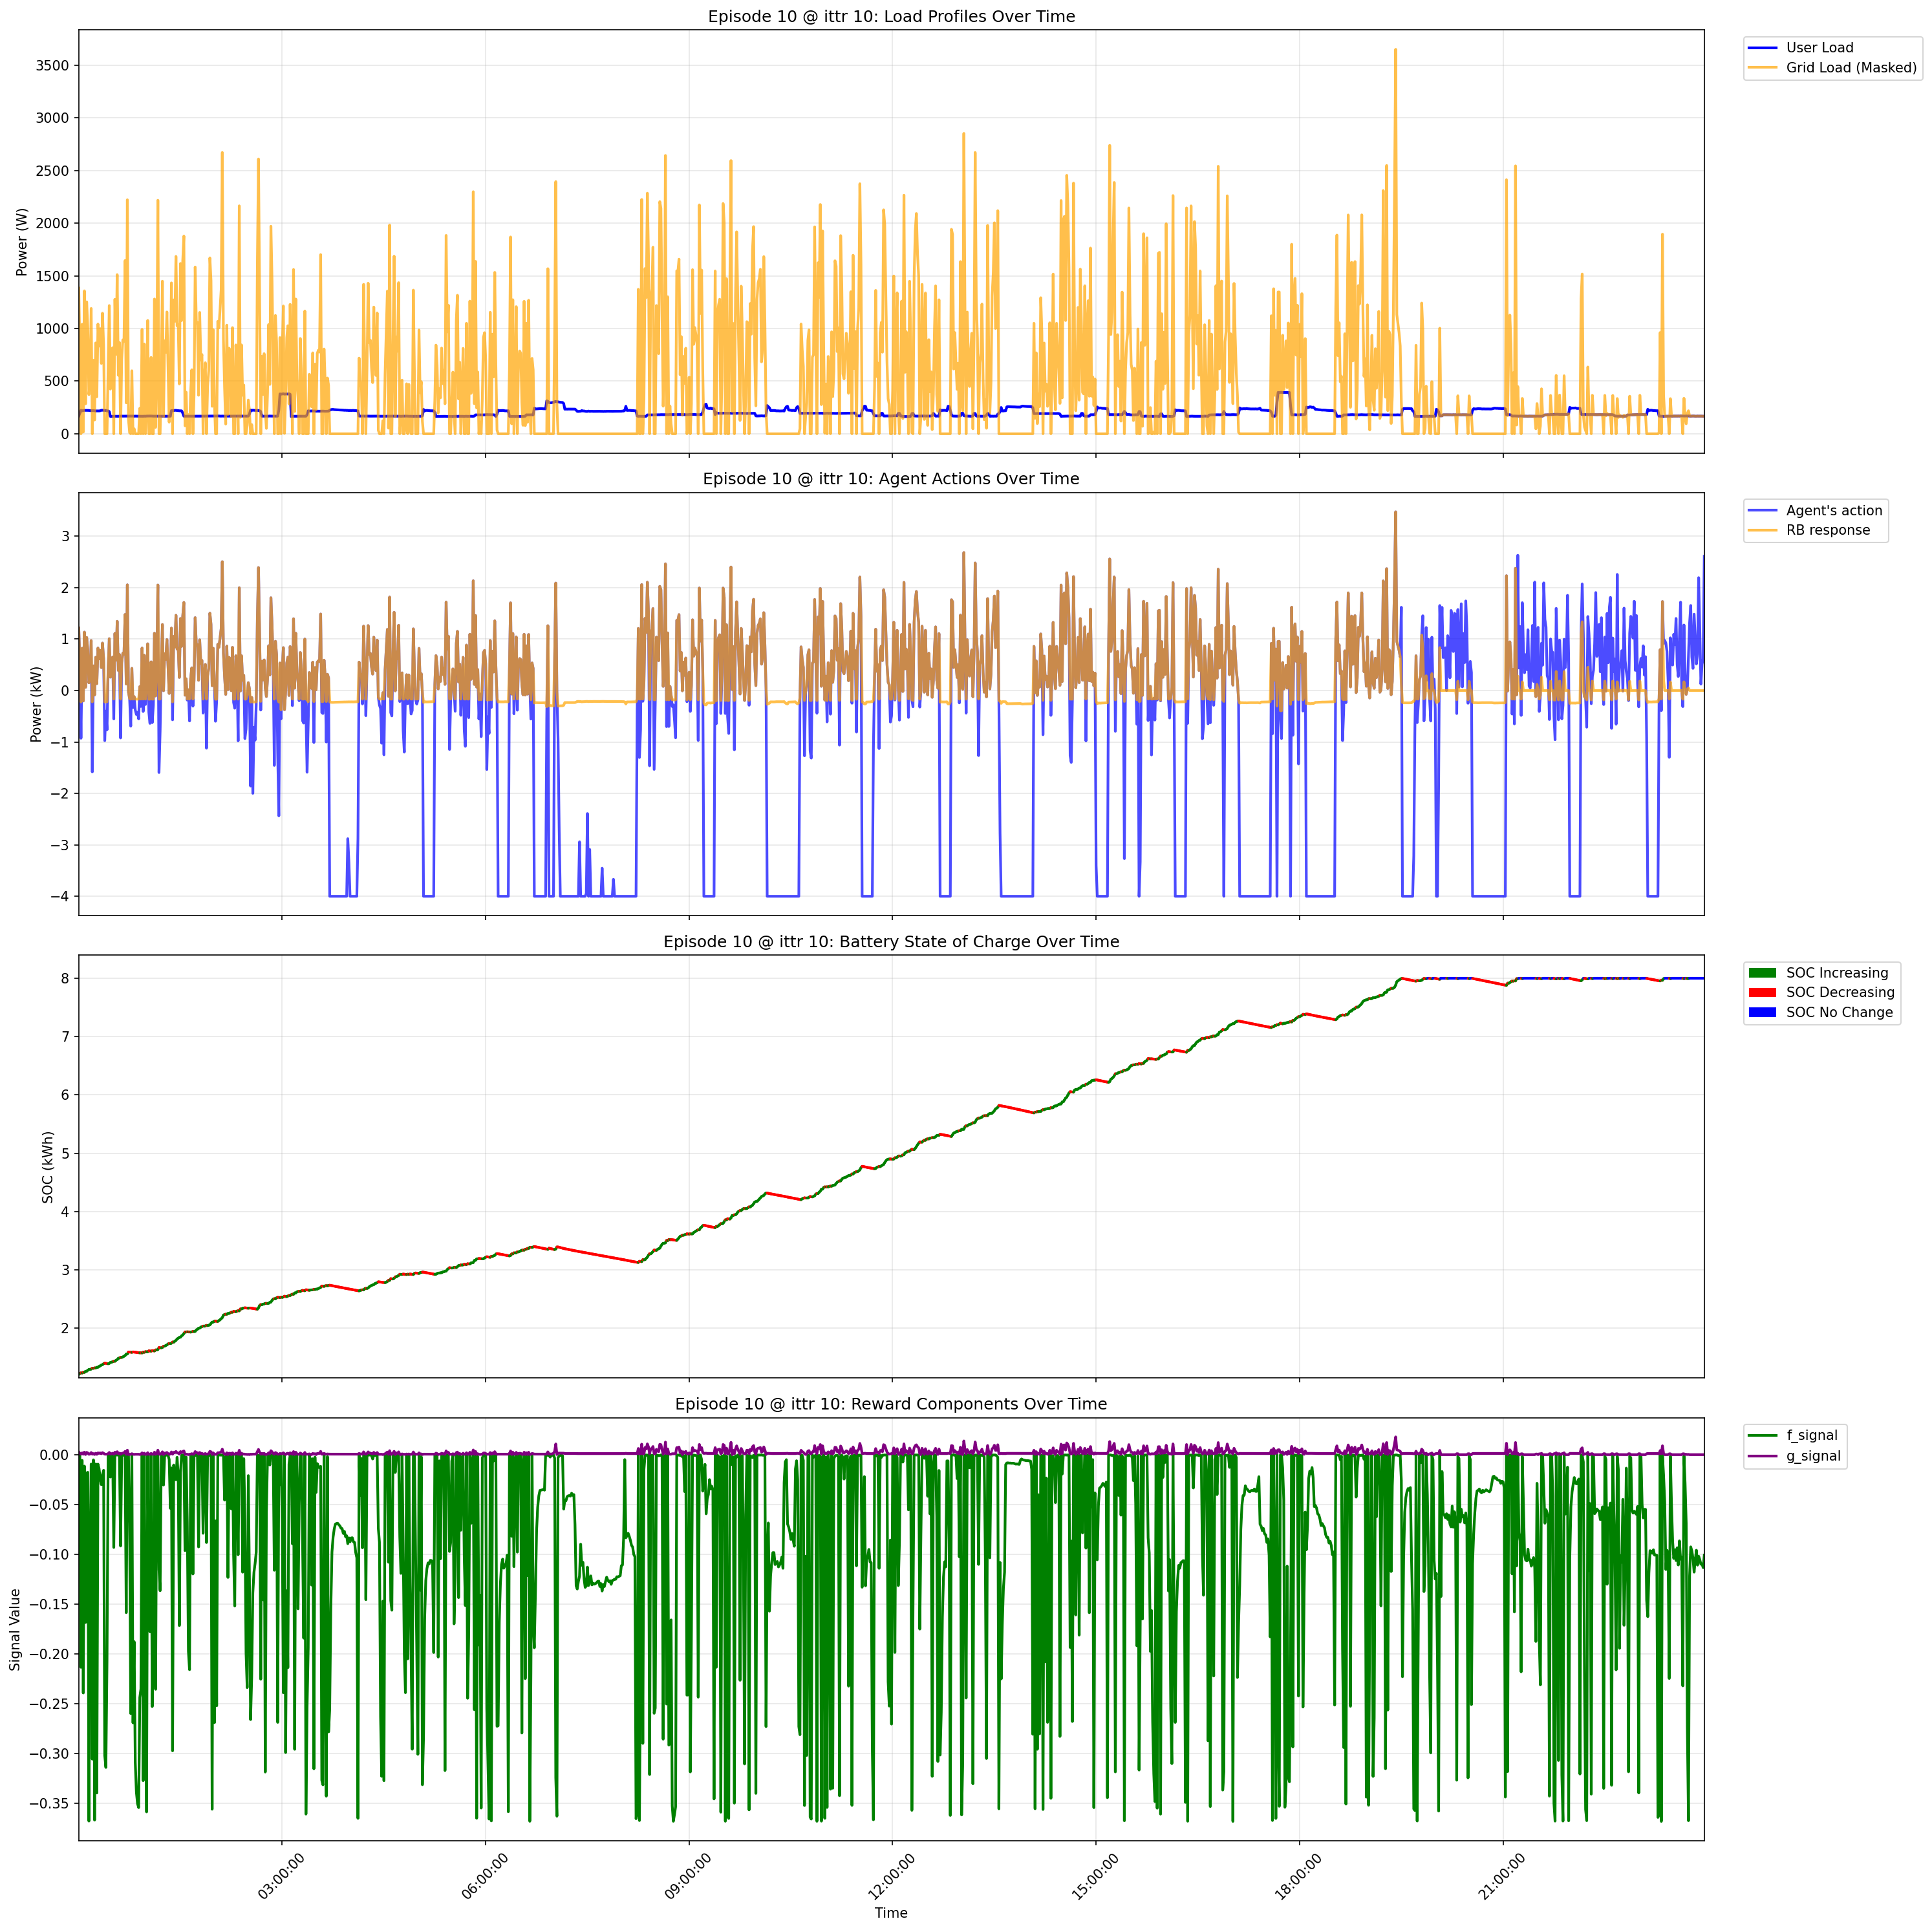

[2025-09-23 13:02:43:624] Episode overview plot saved to: experiments/20250811_044555_action_continuous_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_w_signals/episode_0010_overview.svg


In [10]:
# Example usage: Plot episode overview for first episode
# uncomment the following lines to run the example

if episode_info_dfs is not None and len(episode_info_dfs) > 0:
    # Select an episode for demonstration
    sample_episode = episode_info_dfs[10]
    episode = sample_episode['episode'].iloc[0] if 'episode' in sample_episode.columns else 0

    print_log(f"Plotting episode overview for episode {episode:04d}...")

    # Create save path
    save_path = expt_phrase_folder / "graphs" / "per_episode_w_signals" / f"episode_{episode:04d}_overview.svg"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    show=True  # Set to False to avoid displaying during batch processing
    
    # Plot episode overview
    fig = plot_episode_overview(
        sample_episode, 
        save_path=None,
        use_datetime=True, 
        show=show
    )

    if not show:
        del fig
    
    print_log(f"Episode overview plot saved to: {save_path}")
    
else:
    print_log("No episode data available - creating sample episode overview plot...")
    
    # Create sample episode data for demonstration
    time_steps = 144  # 24 hours * 6 (10-minute intervals)
    sample_episode_df = pd.DataFrame({
        'datetime': pd.date_range('2025-01-01 00:00:00', periods=time_steps, freq='10T'),
        'user_load (W)': 2000 + 1000 * np.sin(np.linspace(0, 4*np.pi, time_steps)) + 200 * np.random.random(time_steps),
        'grid_load (W)': 1800 + 800 * np.sin(np.linspace(0.5, 4.5*np.pi, time_steps)) + 150 * np.random.random(time_steps),
        'battery_soc (kWh)': 50 + 20 * np.sin(np.linspace(0, 2*np.pi, time_steps)) + 2 * np.random.random(time_steps),
        'total_cost': np.random.random(time_steps) * 10,
        'privacy_cost': np.random.random(time_steps) * 5,
        'electricity_cost': np.random.random(time_steps) * 8,
        'episode_index': [0] * time_steps
    })
    
    fig = plot_episode_overview(sample_episode_df, 0, use_datetime=True, show=True)

In [15]:
# using item getter for specific episodes
from operator import itemgetter

for episode_df in itemgetter(100, 300, 600)(episode_info_dfs):

    episode = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else 0

    print_log(f"Plotting episode overview for episode {episode:04d}...")

    # Create save path
    save_path = expt_phrase_folder / "graphs" / "per_episode_w_signals" / f"episode_{episode:04d}_overview.svg"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    show=False  # Set to False to avoid displaying during batch processing
    
    # Plot episode overview
    fig = plot_episode_overview(
        episode_df, 
        save_path=save_path,
        use_datetime=True, 
        show=False
    )

    if not show:
        del fig
    
    print_log(f"Episode overview plot saved to: {save_path}")

IndexError: list index out of range

In [10]:
for episode_df in episode_info_dfs:

    episode = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else 0

    print_log(f"Plotting episode overview for episode {episode:04d}...")

    # Create save path
    save_path = expt_phrase_folder / "graphs" / "per_episode_w_signals" / f"episode_{episode:04d}_overview.svg"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    show=False  # Set to False to avoid displaying during batch processing
    
    # Plot episode overview
    fig = plot_episode_overview(
        episode_df, 
        save_path=save_path,
        use_datetime=True, 
        show=False
    )

    if not show:
        del fig
    
    print_log(f"Episode overview plot saved to: {save_path}")

[2025-09-23 16:55:35:899] Plotting episode overview for episode 0000...
[2025-09-23 16:55:36:319] Episode overview plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_w_signals/episode_0000_overview.svg
[2025-09-23 16:55:36:319] Plotting episode overview for episode 0001...
[2025-09-23 16:55:36:728] Episode overview plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_w_signals/episode_0001_overview.svg
[2025-09-23 16:55:36:729] Plotting episode overview for episode 0002...
[2025-09-23 16:55:37:138] Episode overview plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_w_signals/episode_0002_overview.svg
[2025-09-23 16:55:37:139] Plotting episode overview for episode 0003...
[2025-09-23 16:55:37:553] Episode overview plot saved to: experiments/20250814_020526_action_discrete_reward_lam

## H-Network Analysis Functions

Functions to analyze how the battery action affects H-network predictions, loss components, and likelihood analysis for individual episodes.

In [7]:
def plot_h_network_loss_analysis(episode_df, zoomed=False, save_path=None, use_datetime=False, show=True, likelihood_analysis_only=False):
    """
    Plot H-network loss analysis with predictions, computed loss, likelihood, and f_signal.
    
    Args:
        episode_df: DataFrame containing episode information
        zoomed: If True, apply zoomed y-axis limits for better visualization
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
        likelihood_analysis_only: If True, only plot the loss and likelihood analysis subplot (i.e. 2nd row one)
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, dpi=150)

    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else 0
    episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else 0
    
    # First subplot: H-network predicted mean, log_var, and target
    valid_mask = ~(episode_df['f_signal-predicted_mean'].isna() | 
                   episode_df['f_signal-target'].isna())
    
    if use_datetime and 'datetime' in episode_df.columns:
        x_valid = episode_df.loc[valid_mask, 'datetime']
    else:
        x_valid = np.array(x_values)[valid_mask]
    
    predicted_mean = episode_df.loc[valid_mask, 'f_signal-predicted_mean'].copy()
    target = episode_df.loc[valid_mask, 'f_signal-target'].copy()
    
    # Handle discrete action case: scale predicted_mean and target by AGGREGATE_STEP_SIZE
    if action_type == "discrete":
        predicted_mean = predicted_mean * AGGREGATE_STEP_SIZE
        target = target * AGGREGATE_STEP_SIZE
    
    # Plot predicted mean
    ax1.plot(x_valid, predicted_mean, label='H-network Predicted Mean', color='blue', linewidth=2)
    
    # Plot predicted log variance only for continuous action case
    if action_type != "discrete":
        predicted_log_var = episode_df.loc[valid_mask, 'f_signal-predicted_log_var']
        
        # Plot predicted log variance (if available)
        if not predicted_log_var.isna().all():
            ax1.plot(x_valid, predicted_log_var, label='H-network Predicted Log Var', color='orange', linewidth=2, alpha=0.7)
            
            # Add confidence interval using log variance
            predicted_std = np.sqrt(np.exp(predicted_log_var))
            ax1.fill_between(x_valid, 
                            predicted_mean - predicted_std, 
                            predicted_mean + predicted_std, 
                            alpha=0.2, color='blue', label='Predicted ±1σ')
    
    # Plot target
    target_label = 'Target (y_{t+1}) = std user load' if action_type != "discrete" else 'Target (y_{t+1}) = user load (W)'
    ax1.plot(x_valid, target, label=target_label, color='red', linewidth=2)

    ax1.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: H-network Predictions vs Target' + (f' (Zoomed)' if zoomed else ''))
    ax1.set_ylabel('Signal Value' if action_type != "discrete" else 'Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    if zoomed:
        # Compute y-axis limits based on the data
        y_min = min(predicted_mean.min(), target.min())
        y_max = max(predicted_mean.max(), target.max())
        y_range = y_max - y_min
        ax1.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Second subplot: Loss analysis and likelihood
    if action_type != "discrete":
        # Continuous case: use original log variance for loss computation
        predicted_log_var = episode_df.loc[valid_mask, 'f_signal-predicted_log_var']
        
        if not (predicted_mean.isna().all() or predicted_log_var.isna().all() or target.isna().all()):
            # Convert to torch tensors for loss computation (use original unscaled values for loss)
            mean_tensor = torch.tensor(episode_df.loc[valid_mask, 'f_signal-predicted_mean'].values, dtype=torch.float32)
            var_tensor = torch.exp(torch.tensor(predicted_log_var.values, dtype=torch.float32))
            target_tensor = torch.tensor(episode_df.loc[valid_mask, 'f_signal-target'].values, dtype=torch.float32)
            
            # Compute GaussianNLLLoss
            loss_fn = nn.GaussianNLLLoss(reduction='none')  # 'none' to get per-sample loss
            computed_loss = loss_fn(mean_tensor, target_tensor, var_tensor).detach().numpy()
            
            # Compute likelihood: exp(-loss)
            likelihood = np.exp(-computed_loss)
            
            # Also compute the product of likelihood and negative loss for comparison
            likelihood_neg_loss_product = likelihood * (-computed_loss)
            
            # Plot computed loss
            ax2.plot(x_valid, computed_loss, label='Computed Loss (GaussianNLLLoss)', 
                    color='red', linewidth=2, alpha=0.8)
            
            # Plot likelihood
            ax2.plot(x_valid, likelihood, label='Likelihood (exp(-loss))', 
                    color='green', linewidth=2, alpha=0.8)
            
            # Plot likelihood * (-loss) product
            ax2.plot(x_valid, likelihood_neg_loss_product, label='Likelihood × (-Loss) = f_signal', 
                    color='purple', linewidth=2, alpha=0.7)

            ax2.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: H-network Loss and Likelihood Analysis' + (f' (Zoomed)' if zoomed else ''))
            ax2.set_xlabel(x_label)
            ax2.set_ylabel('Value')
            ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
            ax2.grid(True, alpha=0.3)

            if zoomed:
                # compute the y-axis limits based on the data
                ax2.set_ylim(min(likelihood_neg_loss_product) - np.std(likelihood_neg_loss_product), 
                            np.median(computed_loss) + 2 * min(np.std(computed_loss), 3))
                ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
                ax2.grid(True, alpha=0.3)
    
    else:
        # Discrete case: categorical likelihood analysis (mirroring continuous case structure)
        if not (predicted_mean.isna().all() or target.isna().all()):
            # Use original unscaled values for categorical distance computation
            predicted_action_idx = episode_df.loc[valid_mask, 'f_signal-predicted_mean'].values
            target_action_idx = episode_df.loc[valid_mask, 'f_signal-target'].values
        
            # Compute categorical distance (in action index space)
            categorical_distance = np.abs(predicted_action_idx - target_action_idx)
            
            # Component 1: Categorical "loss" (analogous to GaussianNLLLoss)
            log_categorical_distance = np.log1p(categorical_distance)
            
            # Component 2: Categorical "likelihood" (analogous to exp(-loss))
            likelihood_analog = np.exp(-categorical_distance)
            
            # Component 3: f_signal analog (analogous to likelihood × (-loss))
            negative_log_categorical_distance = -log_categorical_distance
            f_signal_analog = likelihood_analog * negative_log_categorical_distance
            
            # Plot categorical distance (analogous to computed loss)
            ax2.plot(x_valid, log_categorical_distance, label='Categorical Distance (Cross-Entropy Proxy)', 
                    color='red', linewidth=2, alpha=0.8)
            
            # Plot likelihood analog (analogous to likelihood)
            ax2.plot(x_valid, likelihood_analog, label='Likelihood Analog (exp(-distance))', 
                    color='green', linewidth=2, alpha=0.8)
            
            # Plot f_signal analog (analogous to likelihood × (-loss))
            ax2.plot(x_valid, f_signal_analog, label='Likelihood × (-Distance) = f_signal analog', 
                    color='purple', linewidth=2, alpha=0.7)
            
            # Plot true f_signal from H-network for comparison (discrete case only)
            true_f_signal = episode_df.loc[valid_mask, 'f_signal']
            if not true_f_signal.isna().all():
                ax2.plot(x_valid, true_f_signal, label='True f_signal (H-network output)', 
                        color='orange', linewidth=2, linestyle='--', alpha=0.6)

            ax2.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: H-network Categorical Loss and Likelihood Analysis (Discrete Action Space)' + (f' (Zoomed)' if zoomed else ''))
            ax2.set_xlabel(x_label)
            ax2.set_ylabel('Value')
            ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
            ax2.grid(True, alpha=0.3)

            if zoomed:
                # Focus primarily on the f_signal analog (similar to continuous case)
                primary_y_min = min(f_signal_analog.min(), true_f_signal.min())
                primary_y_max = f_signal_analog.max()
                primary_range = primary_y_max - primary_y_min
                
                # Set zoom bounds based on f_signal analog with padding
                ax2.set_ylim(primary_y_min - 0.1 * primary_range, 
                           np.median(log_categorical_distance) + 2 * min(np.std(likelihood_analog), 3))
        else:
            # If no valid data, show empty plot with message
            ax2.text(0.5, 0.5, 'No valid data for categorical likelihood analysis', 
                    transform=ax2.transAxes, ha='center', va='center', fontsize=14)
            ax2.set_title(f'Episode {episode_data_idx} @ ittr {episode_ittr}: H-network Categorical Loss and Likelihood Analysis (Discrete Action Space)')
            ax2.set_xlabel(x_label)
            ax2.set_ylabel('Value')
            ax2.grid(True, alpha=0.3)

    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        formatter = DateFormatter('%H:%M:%S')
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)
    
    if likelihood_analysis_only:
        fig.delaxes(ax1)
        ax = ax2
        ax1 = None
        ax2 = ax

    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close(fig)
        plt.close('all')
    return fig

[2025-09-24 21:40:48:589] Plotting H-network loss analysis for episode 0010...


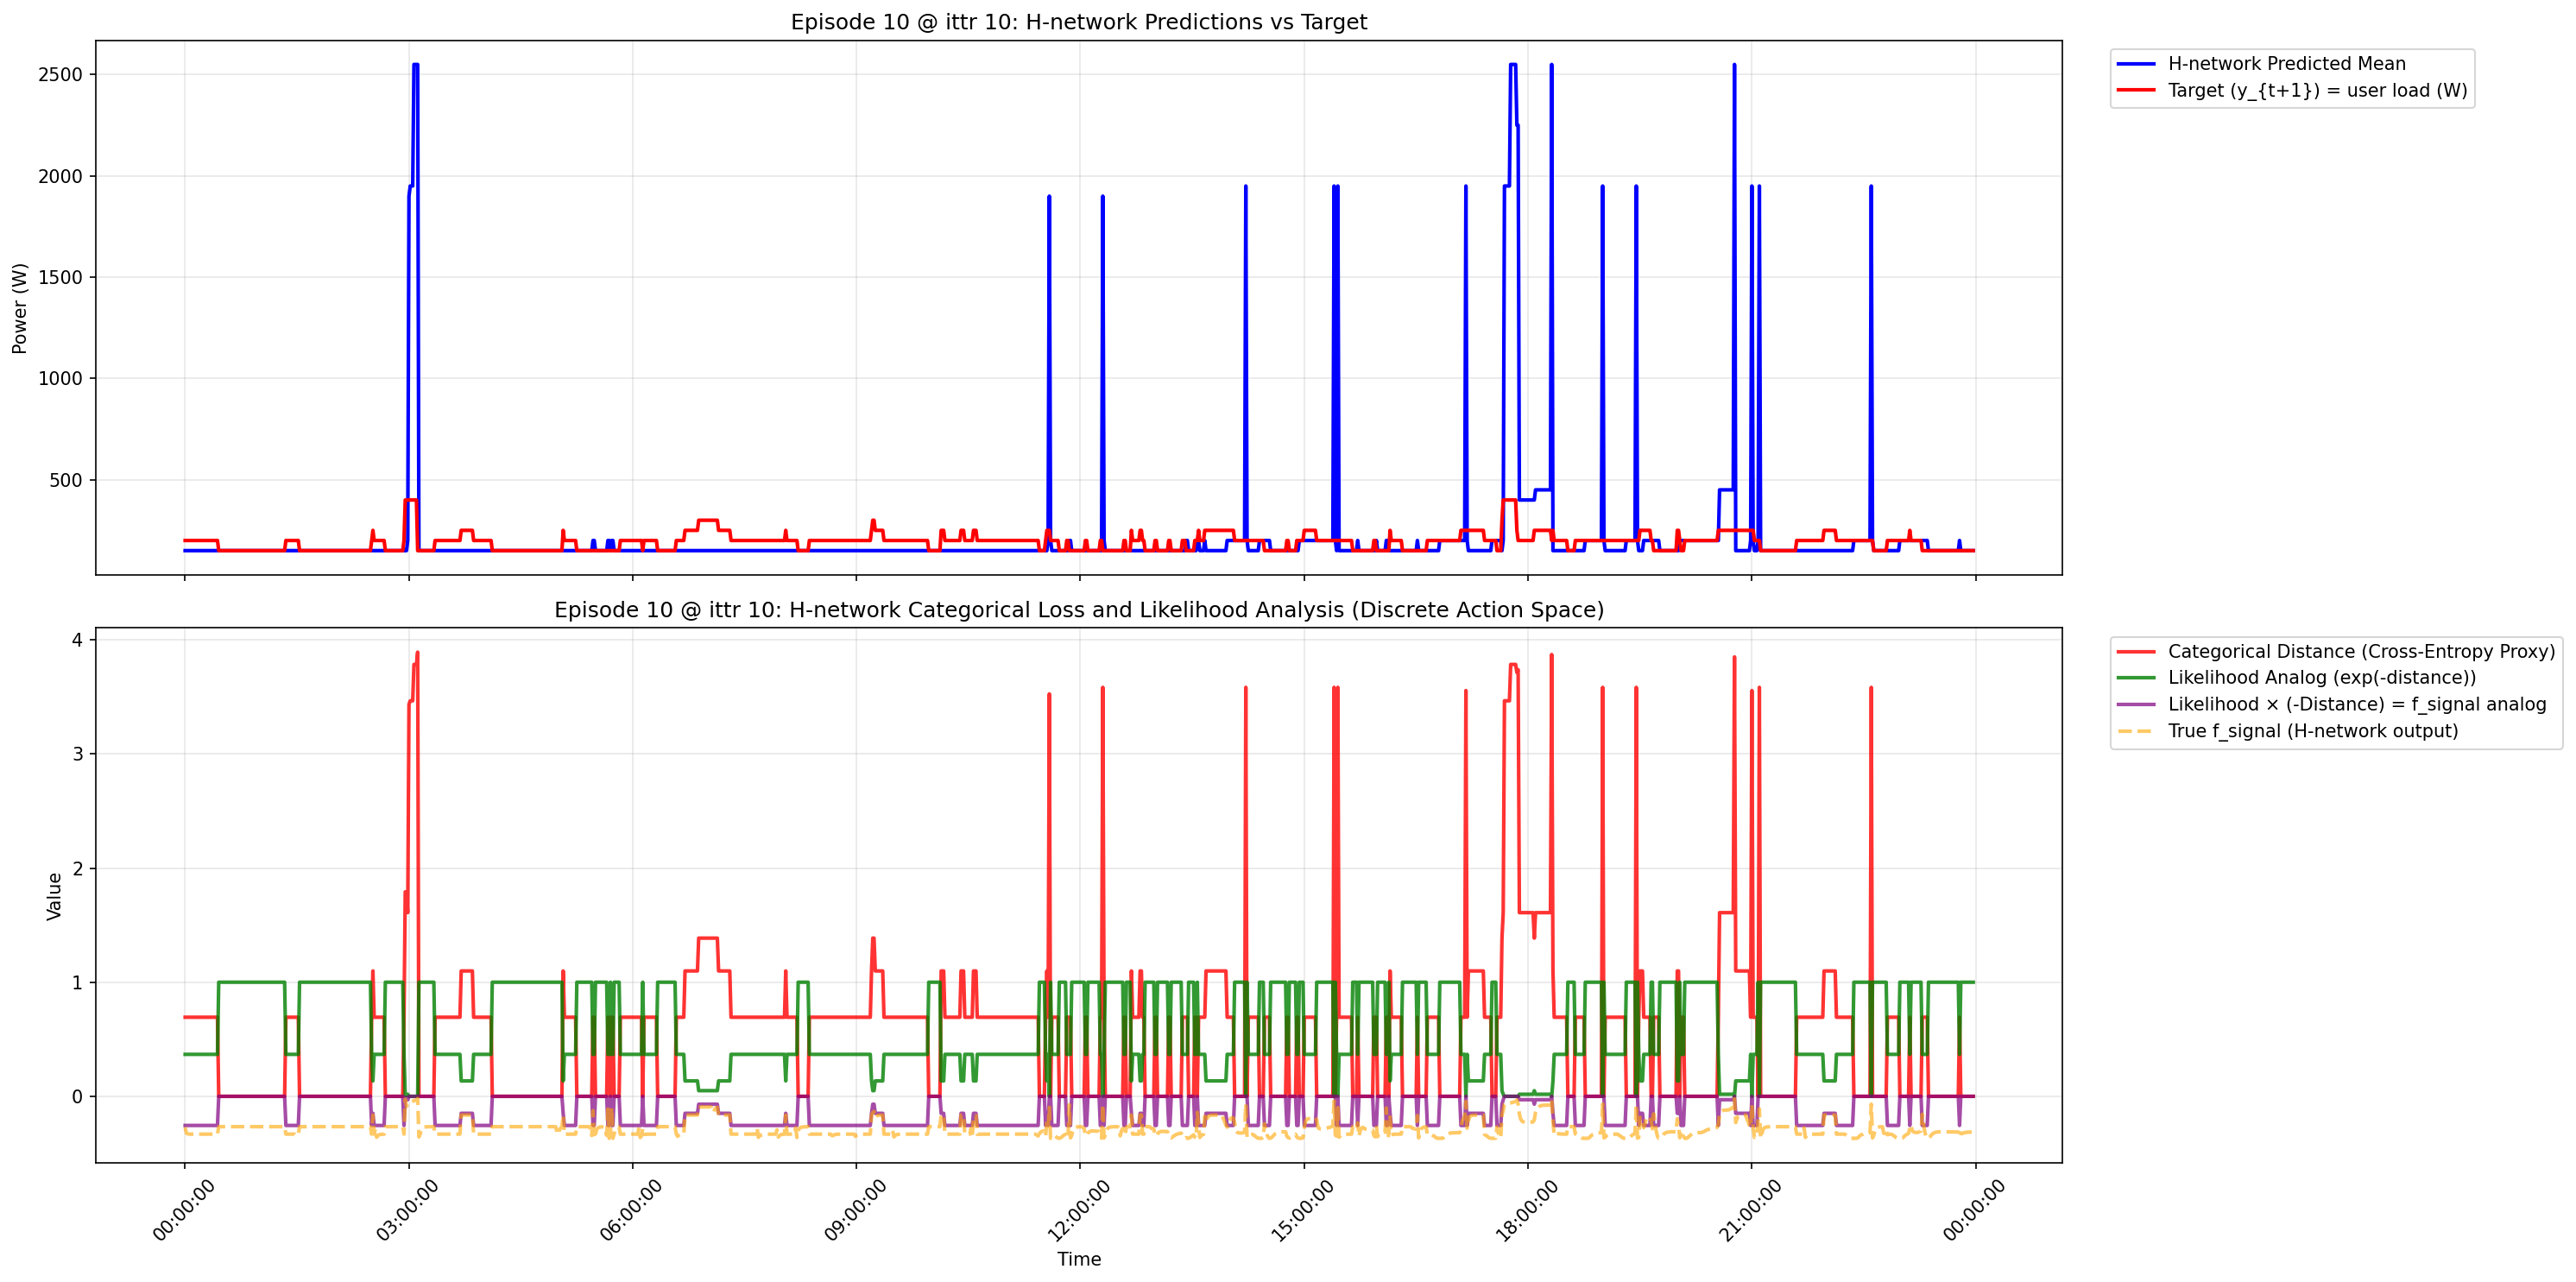

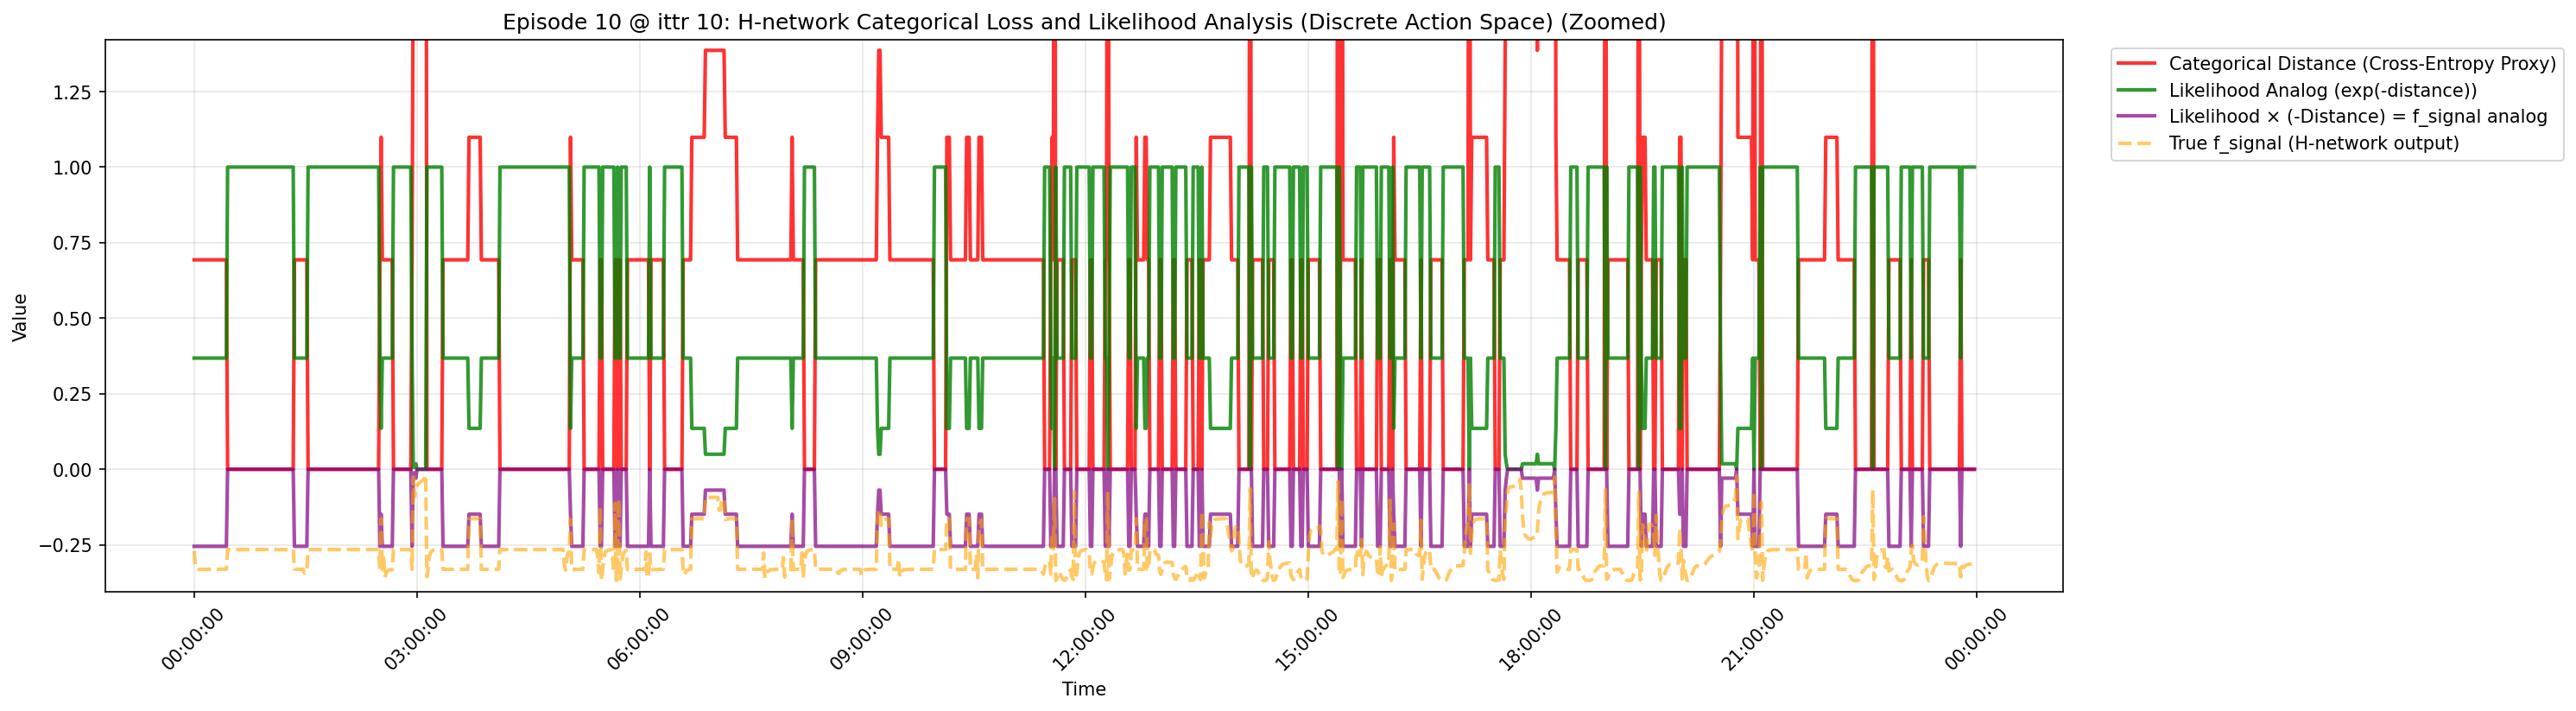

[2025-09-24 21:40:49:060] H-network loss analysis (normal) plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_h_network_loss/episode_0010_hnetwork_loss.png
[2025-09-24 21:40:49:060] H-network loss analysis (zoomed) plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_h_network_loss_zoomed/episode_0010_hnetwork_loss_zoomed.png


In [ ]:
# Example usage: Plot H-network loss analysis for first episode
# uncomment the following lines to run the example

# if episode_info_dfs is not None and len(episode_info_dfs) > 0:
#     # Select first episode for demonstration
#     sample_episode = episode_info_dfs[10]
    
#     episode = sample_episode['episode'].iloc[0] if 'episode' in sample_episode.columns else 0
    
#     # Create save path
#     save_path = expt_phrase_folder / "graphs" / "per_episode_h_network_loss" / f"episode_{episode:>04d}_hnetwork_loss.png"
#     save_path2 = expt_phrase_folder / "graphs" / "per_episode_h_network_loss_zoomed" / f"episode_{episode:>04d}_hnetwork_loss_zoomed.png"

#     if not save_path.parent.exists():
#         save_path.parent.mkdir(parents=True, exist_ok=True)
    
#     print_log(f"Plotting H-network loss analysis for episode {episode:>04d}...")

#     show=True  # Set to False to avoid displaying during batch processing

#     # Plot H-network loss analysis
#     fig = plot_h_network_loss_analysis(
#         sample_episode, 
#         # save_path=save_path,
#         save_path=None,
#         use_datetime=True, 
#         show=show
#     )

#     # plot H-network loss analysis (a zoomed version)
#     fig_zoomed = plot_h_network_loss_analysis(
#         sample_episode, 
#         # save_path=save_path2,
#         save_path=None,
#         use_datetime=True, 
#         show=show,
#         zoomed=True,
#         likelihood_analysis_only=True
#     )

#     print_log(f"H-network loss analysis (normal) plot saved to: {save_path}")
#     print_log(f"H-network loss analysis (zoomed) plot saved to: {save_path2}")
    
# else:
#     print_log("No episode data available - creating sample H-network loss analysis...")
    
#     # Create sample episode data for demonstration
#     time_steps = 144  # 24 hours * 6 (10-minute intervals)
#     sample_episode_df = pd.DataFrame({
#         'datetime': pd.date_range('2025-01-01 00:00:00', periods=time_steps, freq='10T'),
#         'user_load (W)': 2000 + 1000 * np.sin(np.linspace(0, 4*np.pi, time_steps)) + 200 * np.random.random(time_steps),
#         'grid_load (W)': 1800 + 800 * np.sin(np.linspace(0.5, 4.5*np.pi, time_steps)) + 150 * np.random.random(time_steps),
#         'h_network_prediction (W)': 1900 + 850 * np.sin(np.linspace(0.3, 4.3*np.pi, time_steps)) + 100 * np.random.random(time_steps),
#         'h_network_target (W)': 1850 + 900 * np.sin(np.linspace(0.2, 4.2*np.pi, time_steps)) + 80 * np.random.random(time_steps),
#         'h_network_loss_total': np.random.random(time_steps) * 5 + 1,
#         'h_network_loss_likelihood': np.random.random(time_steps) * 3 + 0.5,
#         'episode_index': [0] * time_steps
#     })
    
#     fig = plot_h_network_loss_analysis(sample_episode_df, 0, use_datetime=True, show=True)

In [12]:
# using item getter for specific episodes
from operator import itemgetter

for episode_df in itemgetter(100, 300, 600)(episode_info_dfs):
    # Select first episode for demonstration
    sample_episode = episode_df

    episode = sample_episode['episode'].iloc[0] if 'episode' in sample_episode.columns else 0
    
    # Create save path
    save_path = expt_phrase_folder / "graphs" / "per_episode_h_network_loss" / f"episode_{episode:>04d}_hnetwork_loss.svg"
    save_path2 = expt_phrase_folder / "graphs" / "per_episode_h_network_loss_zoomed" / f"episode_{episode:>04d}_hnetwork_loss_zoomed.svg"

    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)
    
    print_log(f"Plotting H-network loss analysis for episode {episode:>04d}...")

    show=True  # Set to False to avoid displaying during batch processing

    # Plot H-network loss analysis
    fig = plot_h_network_loss_analysis(
        sample_episode, 
        save_path=save_path,
        use_datetime=True, 
        show=show
    )

    # plot H-network loss analysis (a zoomed version)
    fig_zoomed = plot_h_network_loss_analysis(
        sample_episode, 
        save_path=save_path2,
        use_datetime=True, 
        show=show,
        zoomed=True
    )

    print_log(f"H-network loss analysis (normal) plot saved to: {save_path}")
    print_log(f"H-network loss analysis (zoomed) plot saved to: {save_path2}")

[2025-08-25 20:02:22:130] Plotting H-network loss analysis for episode 0101...


/tmp/ipykernel_16824/2139257042.py:200: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


[2025-08-25 20:02:22:463] H-network loss analysis (normal) plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/per_episode_h_network_loss/episode_0101_hnetwork_loss.svg
[2025-08-25 20:02:22:463] H-network loss analysis (zoomed) plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/per_episode_h_network_loss_zoomed/episode_0101_hnetwork_loss_zoomed.svg
[2025-08-25 20:02:22:464] Plotting H-network loss analysis for episode 0301...
[2025-08-25 20:02:22:787] H-network loss analysis (normal) plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/per_episode_h_network_loss/episode_0301_hnetwork_loss.svg
[2025-08-25 20:02:22:787] H-network loss analysis (zoomed) plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/per_episode_h_network_loss_zoomed/episode_0301_hnetwork_loss_zoomed.svg
[2025-08-25 20:02:22:787] Plotting H-network 

In [8]:
for episode_df in episode_info_dfs:
    episode = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else 0

    # Create save path
    save_path = expt_phrase_folder / "graphs" / "per_episode_h_network_loss" / f"episode_{episode:>04d}_hnetwork_loss.svg"
    save_path2 = expt_phrase_folder / "graphs" / "per_episode_h_network_loss_zoomed" / f"episode_{episode:>04d}_hnetwork_loss_zoomed.svg"

    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    if not save_path2.parent.exists():
        save_path2.parent.mkdir(parents=True, exist_ok=True)
    
    print_log(f"Plotting H-network loss analysis for episode {episode:>04d}...")

    show=False  # Set to False to avoid displaying during batch processing

    # Plot H-network loss analysis
    # fig = plot_h_network_loss_analysis(
    #     episode_df, 
    #     save_path=save_path,
    #     use_datetime=True, 
    #     show=show
    # )

    # plot H-network loss analysis (a zoomed version)
    fig_zoomed = plot_h_network_loss_analysis(
        episode_df, 
        save_path=save_path2,
        use_datetime=True, 
        show=show,
        zoomed=True,
        likelihood_analysis_only=True
    )

    # print_log(f"H-network loss analysis (normal) plot saved to: {save_path}")
    print_log(f"H-network loss analysis (zoomed) plot saved to: {save_path2}")

[2025-09-24 21:44:50:769] Plotting H-network loss analysis for episode 0000...
[2025-09-24 21:44:50:898] H-network loss analysis (zoomed) plot saved to: experiments/20250811_044555_action_continuous_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_h_network_loss_zoomed/episode_0000_hnetwork_loss_zoomed.svg
[2025-09-24 21:44:50:898] Plotting H-network loss analysis for episode 0001...
[2025-09-24 21:44:50:992] H-network loss analysis (zoomed) plot saved to: experiments/20250811_044555_action_continuous_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_h_network_loss_zoomed/episode_0001_hnetwork_loss_zoomed.svg
[2025-09-24 21:44:50:993] Plotting H-network loss analysis for episode 0002...
[2025-09-24 21:44:51:172] H-network loss analysis (zoomed) plot saved to: experiments/20250811_044555_action_continuous_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_h_network_loss_zoomed/episode_0002_hnetwork_loss_zoomed.svg
[2025-09-24 21:44:51:172] Plotting H-

## Power Spectral Density & Mutual Information Analysis

Functions to plot power spectral density analysis and mutual information visualization for episodes with curriculum learning information.

Before plotting, it will be great to pre-compute the MI and extra cost for all loaded episodes.

MI is estimated using https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

In the paper `Privacy-Cost Management in Smart Meters With Mutual-Information-Based Reinforcement Learning`, the parameter $k$ (in KNN estimation) is set to 4 

The extra cost can be computed as

$$\int (B_t - Y_t)h_t \triangle_t$$

where $B_t$ is the battery state of charge at time t; $Y_t$ is the user load at time t, $h_t$ is the time-of-use price per kWh, $\triangle_t$ is the time passed 

In [13]:
def calculate_mutual_information_per_episode(episode_info_dfs, k=4):
    """
    Calculate mutual information between masked grid load and user load for each episode.
    
    Args:
        episode_info_dfs: List of episode DataFrames
        k: Number of neighbors for KNN estimation (default=4 as per paper)
    
    Returns:
        Dictionary containing:
        - 'mi_values': List of mutual information values for each episode
        - 'episode_ittr': List of episode iteration numbers (during training environment)
        - 'episode_data_idx':  List of episode data indices (in the data loader object)
    """
    mi_results = {
        'mi_values': [],
        'episode_ittr': [],
        'episode_data_idx': []
    }
    
    for i, episode_df in enumerate(episode_info_dfs):
        try:
            episode_ittr = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else (i+1)
            episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else 0
            
            # Create a copy to avoid modifying the original dataframe
            df_clean = episode_df.copy()
            
            # Remove rows with NaN values in either grid_load or user_load columns
            df_clean = df_clean.dropna(subset=['grid_load (W)', 'user_load (W)'])
            
            # Check if we have enough data points after removing NaN values
            if len(df_clean) < k + 1:  # Need at least k+1 points for KNN
                print_log(f"Episode {episode_ittr:04d} (episode_data_idx: {episode_data_idx}): Not enough valid data points ({len(df_clean)}) after removing NaN values")
                mi_results['mi_values'].append(np.nan)
                mi_results['episode_ittr'].append(episode_ittr)
                mi_results['episode_data_idx'].append(episode_data_idx)
                continue
            
            # Extract the features: masked grid load (X) and user load (y)
            X = df_clean['grid_load (W)'].values.reshape(-1, 1)  # Masked grid load (features)
            y = df_clean['user_load (W)'].values  # User load (continuous target)
            
            # Calculate mutual information using scikit-learn for regression
            # mutual_info_regression handles continuous variables directly
            mi = mutual_info_regression(X, y, n_neighbors=k, random_state=42)
            
            mi_results['mi_values'].append(mi[0])  # mi is an array, we take the first element
            mi_results['episode_ittr'].append(episode_ittr)
            mi_results['episode_data_idx'].append(episode_data_idx)
            
            if i % 100 == 0:  # Print progress every 100 episodes
                print_log(f"Processed episode {i+1}/{len(episode_info_dfs)} (episode_data_idx: {episode_data_idx})")

            del df_clean  # Free memory after processing
                
        except Exception as e:
            # Get episode index even in case of error
            print_log(f"Error calculating MI for episode {i} (episode_data_idx: {episode_data_idx}): {str(e)}")
            mi_results['mi_values'].append(np.nan)  # Add NaN for failed calculations
            mi_results['episode_ittr'].append(episode_ittr)
            mi_results['episode_data_idx'].append(episode_data_idx)

    print_log(f"Calculated mutual information for {len(mi_results['mi_values'])} episodes")
    return mi_results

In [14]:
# Calculate mutual information for all episodes with enhanced metadata
print_log("Starting mutual information calculation with curriculum learning support...")
mi_results = calculate_mutual_information_per_episode(episode_info_dfs, k=4)

# Extract the components from the results
mutual_info_values = mi_results['mi_values']
episode_training_idx = mi_results['episode_ittr']  # Use episode_data_idx for 
episode_data_idx = mi_results['episode_data_idx']  # Use episode_ittr for plotting

# Create a comprehensive DataFrame with episode, episode_index, MI values, and curriculum metadata
mi_df = pd.DataFrame({
    'episode_training_idx': episode_training_idx,         # Index in the episode_info_dfs list
    'episode_data_idx': episode_data_idx,                   # Episode index from the dataset
    'mutual_information': mutual_info_values            # MI values
})

# Add curriculum metadata if available
if 'episode_metadata_df' in locals():
    # Merge with metadata based on episode_index
    # mi_df = mi_df.merge(episode_metadata_df[['episode_idx', 'episode_content_id', 'episode_length_days', 
    #                                         'curriculum_phase', 'data_loader_type']], 
    #                    left_on='episode_index', right_on='episode_idx', how='left')
    mi_df = mi_df.merge(episode_metadata_df[['episode_training_idx', 'episode_content_id', 'episode_length_days']], how='left')

    print_log("Enhanced MI DataFrame with curriculum metadata:")
    print_log(f"Columns: {list(mi_df.columns)}")
else:
    print_log("Using basic MI DataFrame (no curriculum metadata available)")

print_log(f"Mutual Information Statistics:")
print_log(f"Mean MI: {np.nanmean(mutual_info_values):.6f}")
print_log(f"Std MI: {np.nanstd(mutual_info_values):.6f}")
print_log(f"Min MI: {np.nanmin(mutual_info_values):.6f}")
print_log(f"Max MI: {np.nanmax(mutual_info_values):.6f}")

print_log(f"DataFrame shape: {mi_df.shape}")
print_log(f"Episode index range: {mi_df['episode_data_idx'].min()} to {mi_df['episode_data_idx'].max()}")

# Display curriculum-aware statistics if available
if 'episode_length_days' in mi_df.columns:
    print_log("\nMutual Information by Episode Length:")
    mi_by_length = mi_df.groupby('episode_length_days')['mutual_information'].agg(['count', 'mean', 'std']).round(6)
    print_log(mi_by_length.to_string())

if 'curriculum_phase' in mi_df.columns and mi_df['curriculum_phase'].notna().any():
    print_log("\nMutual Information by Curriculum Phase:")
    mi_by_phase = mi_df.groupby('curriculum_phase')['mutual_information'].agg(['count', 'mean', 'std']).round(6)
    print_log(mi_by_phase.to_string())

mi_df

[2025-09-23 16:57:51:301] Starting mutual information calculation with curriculum learning support...
[2025-09-23 16:57:51:308] Processed episode 1/162 (episode_data_idx: 0)
[2025-09-23 16:57:51:760] Processed episode 101/162 (episode_data_idx: 100)
[2025-09-23 16:57:52:026] Calculated mutual information for 162 episodes
[2025-09-23 16:57:52:029] Enhanced MI DataFrame with curriculum metadata:
[2025-09-23 16:57:52:029] Columns: ['episode_training_idx', 'episode_data_idx', 'mutual_information', 'episode_content_id', 'episode_length_days']
[2025-09-23 16:57:52:029] Mutual Information Statistics:
[2025-09-23 16:57:52:029] Mean MI: 1.228137
[2025-09-23 16:57:52:029] Std MI: 0.406950
[2025-09-23 16:57:52:029] Min MI: 0.128292
[2025-09-23 16:57:52:029] Max MI: 2.220137
[2025-09-23 16:57:52:029] DataFrame shape: (162, 5)
[2025-09-23 16:57:52:029] Episode index range: 0 to 161
[2025-09-23 16:57:52:029] 
Mutual Information by Episode Length:
[2025-09-23 16:57:52:031]                      count 

,episode_training_idx,episode_data_idx,mutual_information,episode_content_id,episode_length_days
0,0,0,1.711102,1e8894d05c89,1
1,1,1,1.739959,0a3457ad5563,1
2,2,2,1.440846,5930d55d98d0,1
3,3,3,1.947203,d5505ebe6bce,1
4,4,4,1.767237,c1ef35814bd7,1
...,...,...,...,...,...
157,157,157,0.443777,d43e391cf44c,1
158,158,158,0.583644,4689a3c22411,1
159,159,159,0.415281,0e3940e6e8f7,1
160,160,160,0.387373,252649594d68,1


In [15]:
# find best 10% and worst 10% episodes based on MI
# MI: lower is better, so we take the smallest values for best and largest for worst
mi_df_describe = mi_df.describe([0.1, 0.25, 0.5, 0.75, 0.9])['mutual_information']
quartile_10th = mi_df_describe['10%']
quartile_25th = mi_df_describe['25%']
quartile_75th = mi_df_describe['75%']
quartile_90th = mi_df_describe['90%']

best_10_percent = mi_df.nsmallest(int(len(mi_df) * 0.1), 'mutual_information')
worst_10_percent = mi_df.nlargest(int(len(mi_df) * 0.1), 'mutual_information')

print_log(f"10th Quartile MI: {quartile_10th:.4f}")
print_log(f"25th Quartile MI: {quartile_25th:.4f}")
print_log(f"75th Quartile MI: {quartile_75th:.4f}")
print_log(f"90th Quartile MI: {quartile_90th:.4f}")
# save the MI information (json), like the mean, median, min, max, std, etc.
mi_stats = {
    'mean': float(np.nanmean(mutual_info_values)),
    'std': float(np.nanstd(mutual_info_values)),
    'min': float(np.nanmin(mutual_info_values)),
    'max': float(np.nanmax(mutual_info_values)),
    'median': float(np.nanmedian(mutual_info_values)),
    '10th_quartile': float(quartile_10th),
    '25th_quartile': float(quartile_25th),
    '75th_quartile': float(quartile_75th),
    '90th_quartile': float(quartile_90th),
    'count': int(len(mutual_info_values)),
    'curriculum_phase_counts': mi_df['curriculum_phase'].value_counts().to_dict() if 'curriculum_phase' in mi_df.columns else None,
    'episode_length_days_counts': mi_df['episode_length_days'].value_counts().to_dict() if 'episode_length_days' in mi_df.columns else None
}

stats_MI_folder = expt_phrase_folder / "graphs" / "per_episode_psd"
if not stats_MI_folder.exists():
    stats_MI_folder.mkdir(parents=True, exist_ok=True)

with open(expt_phrase_folder / "graphs" / "per_episode_psd" / 'stats_MI_stats.json', 'w') as f:
    json.dump(mi_stats, f, indent=4)

# also save the best 10% and worst 10% episodes in json format for further analysis
best_10_percent.to_json(expt_phrase_folder / "graphs" / "per_episode_psd" / 'stats_MI_best_10_percent_episodes.json', orient='records', indent=4)
worst_10_percent.to_json(expt_phrase_folder / "graphs" / "per_episode_psd" / 'stats_MI_worst_10_percent_episodes.json', orient='records', indent=4)

[2025-09-23 16:57:52:061] 10th Quartile MI: 0.5115
[2025-09-23 16:57:52:062] 25th Quartile MI: 1.0866
[2025-09-23 16:57:52:062] 75th Quartile MI: 1.5145
[2025-09-23 16:57:52:062] 90th Quartile MI: 1.6987


In [16]:
import sys
sys.path.append(str(Path.cwd().resolve().joinpath('rl_env')))  # Add parent directory to path for imports
from rl_env.tariff import STANDING_CHARGE
from rl_env.base.env_module import SmartMeterEnvironmentBase

_get_weighted_electricity_cost = SmartMeterEnvironmentBase._get_weighted_electricity_cost

def calculate_extra_cost_per_episode(episode_info_dfs):
    """
    Calculate extra electricity cost incurred by battery actions for each episode.
    
    The extra cost is computed using the _g_signal approach where:
    - We calculate the cost difference between masked grid load and user load
    - The difference (grid_load - user_load) represents the battery charging/discharging effect
    - Cost is computed using time-of-use pricing with proper time weighting
    
    Args:
        episode_info_dfs: List of episode DataFrames
    
    Returns:
        Dictionary containing:
        - 'cost_values': List of extra cost values for each episode (in currency units)
        - 'episode_ittr': List of episode iteration numbers (during training environment)
        - 'episode_data_idx':  List of episode data indices (in the data loader object)
    """
    
    # Improved _g_signal function for cost calculation
    def g_signal(s_t_datetime:datetime, s_t_plus_1_datetime:datetime, power_kw:float) -> float:
        """
        Calculate the cost signal based on elapsed time and power used.
        """
        if s_t_datetime >= s_t_plus_1_datetime:
            return 0.0  # No time elapsed, no cost

        weighted_cost = _get_weighted_electricity_cost(s_t_datetime, s_t_plus_1_datetime)
        return weighted_cost * power_kw + STANDING_CHARGE * ((s_t_plus_1_datetime - s_t_datetime).total_seconds() / (24 * 60 * 60))  # convert seconds to days
    
    cost_results = {
        'cost_values': [],
        'episode_ittr': [],
        'episode_data_idx': []
    }
    
    for i, episode_df in enumerate(episode_info_dfs):
        try:
            # Get the episode index from the dataframe
            episode_ittr = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else (i+1)
            episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else episode_df['episode'].iloc[0]
            
            # Create a copy to avoid modifying the original dataframe
            df_clean = episode_df.copy()
            
            # Remove rows with NaN values in required columns
            required_columns = ['grid_load (W)', 'user_load (W)', 'datetime']
            df_clean = df_clean.dropna(subset=required_columns)
            
            # Check if we have enough data points
            if len(df_clean) < 2:  # Need at least 2 points to calculate time differences
                print_log(f"Episode {episode_ittr:04d} (episode_idx: {episode_data_idx}): Not enough valid data points ({len(df_clean)}) after removing NaN values")
                cost_results['cost_values'].append(np.nan)
                cost_results['episode_ittr'].append(episode_ittr)
                cost_results['episode_data_idx'].append(episode_data_idx)
                continue
            
            # Sort by datetime to ensure proper time ordering
            df_clean = df_clean.sort_values('datetime').reset_index(drop=True)
            
            total_extra_cost = 0.0
            total_grid_cost = 0.0  # Cost of actual grid consumption
            total_user_cost = 0.0  # Cost if no battery was used
            
            # Calculate cost for each time step using _g_signal approach
            for j in range(len(df_clean) - 1):
                # Current and next timestamps
                current_time = df_clean.iloc[j]['datetime']
                next_time = df_clean.iloc[j + 1]['datetime']
                
                # Power values (convert from W to kW)
                grid_load_kw = df_clean.iloc[j]['grid_load (W)'] / 1000.0
                user_load_kw = df_clean.iloc[j]['user_load (W)'] / 1000.0
                
                # Calculate costs using g_signal approach
                grid_cost = g_signal(current_time, next_time, grid_load_kw)
                user_cost = g_signal(current_time, next_time, user_load_kw)
                
                # Accumulate costs
                total_grid_cost += grid_cost
                total_user_cost += user_cost
            
            # Extra cost is the difference between what we actually paid vs what we would have paid
            total_extra_cost = abs(total_grid_cost - total_user_cost)
            
            cost_results['cost_values'].append(total_extra_cost)
            cost_results['episode_ittr'].append(episode_ittr)
            cost_results['episode_data_idx'].append(episode_data_idx)
            
            if i % 100 == 0:  # Print progress every 100 episodes
                print_log(f"Processed episode {i}/{len(episode_info_dfs)} (episode_idx: {episode_data_idx}), Extra cost: £{total_extra_cost:.4f}")

            del df_clean  # Free memory after processing
                
        except Exception as e:
            # Get episode ittr and episode data index even in case of error
            episode_ittr = episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else (i+1)
            episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else episode_df['episode'].iloc[0] if 'episode' in episode_df.columns else i
            print_log(f"Error calculating extra cost for episode {i} (episode_idx: {episode_data_idx}): {str(e)}")
            cost_results['cost_values'].append(np.nan)  # Add NaN for failed calculations
            cost_results['episode_ittr'].append(episode_ittr)
            cost_results['episode_data_idx'].append(episode_data_idx)
    
    print_log(f"Calculated extra electricity cost for {len(cost_results['cost_values'])} episodes")
    return cost_results

In [17]:
# Calculate extra cost for all episodes with enhanced curriculum metadata
print_log("Starting extra electricity cost calculation with curriculum learning support...")
cost_results = calculate_extra_cost_per_episode(episode_info_dfs)

# Extract the components from the results
extra_cost_values = cost_results['cost_values']
episode_training_idx = cost_results['episode_ittr']  # Use episode_data_idx for 
episode_data_idx = cost_results['episode_data_idx']  # Use episode_ittr for plotting

# Create a comprehensive DataFrame with episode, episode_index, cost values, and curriculum metadata
cost_df = pd.DataFrame({
    'episode_training_idx': episode_training_idx,         # Index in the episode_info_dfs list
    'episode_data_idx': episode_data_idx,                   # Episode index from the dataset
    'extra_cost': extra_cost_values                          # Extra cost values
})

# Add curriculum metadata if available
if 'episode_metadata_df' in locals():
    # Merge with metadata based on episode_index
    # cost_df = cost_df.merge(episode_metadata_df[['episode_idx', 'episode_content_id', 'episode_length_days', 
    #                                             'curriculum_phase', 'data_loader_type']], 
    #                        left_on='episode_index', right_on='episode_idx', how='left')
    cost_df = cost_df.merge(episode_metadata_df[['episode_training_idx', 'episode_content_id', 'episode_length_days']], how='left')
    
    print_log("Enhanced Cost DataFrame with curriculum metadata:")
    print_log(f"Columns: {list(cost_df.columns)}")
else:
    print_log("Using basic Cost DataFrame (no curriculum metadata available)")

print_log(f"Extra Electricity Cost Statistics:")
print_log(f"Mean Extra Cost: £{np.nanmean(extra_cost_values):.4f}")
print_log(f"Std Extra Cost: £{np.nanstd(extra_cost_values):.4f}")
print_log(f"Min Extra Cost: £{np.nanmin(extra_cost_values):.4f}")
print_log(f"Max Extra Cost: £{np.nanmax(extra_cost_values):.4f}")

print_log(f"DataFrame shape: {cost_df.shape}")
print_log(f"Episode index range: {cost_df['episode_data_idx'].min()} to {cost_df['episode_data_idx'].max()}")

# Display curriculum-aware cost statistics if available
if 'episode_length_days' in cost_df.columns:
    print_log("\nExtra Cost by Episode Length:")
    cost_by_length = cost_df.groupby('episode_length_days')['extra_cost'].agg(['count', 'mean', 'std']).round(4)
    print_log(cost_by_length.to_string())
    
    # Cost efficiency analysis (cost per day)
    print_log("\nCost Efficiency (Extra Cost per Day) by Episode Length:")
    cost_df['cost_per_day'] = cost_df['extra_cost'] / cost_df['episode_length_days']
    cost_efficiency = cost_df.groupby('episode_length_days')['cost_per_day'].agg(['count', 'mean', 'std']).round(4)
    print_log(cost_efficiency.to_string())

if 'curriculum_phase' in cost_df.columns and cost_df['curriculum_phase'].notna().any():
    print_log("\nExtra Cost by Curriculum Phase:")
    cost_by_phase = cost_df.groupby('curriculum_phase')['extra_cost'].agg(['count', 'mean', 'std']).round(4)
    print_log(cost_by_phase.to_string())

display(cost_df)

[2025-09-23 16:57:52:181] Starting extra electricity cost calculation with curriculum learning support...
[2025-09-23 16:57:52:404] Processed episode 0/162 (episode_idx: 0), Extra cost: £0.1806
[2025-09-23 16:58:10:318] Processed episode 100/162 (episode_idx: 100), Extra cost: £0.2637
[2025-09-23 16:58:23:326] Calculated extra electricity cost for 162 episodes
[2025-09-23 16:58:23:329] Enhanced Cost DataFrame with curriculum metadata:
[2025-09-23 16:58:23:329] Columns: ['episode_training_idx', 'episode_data_idx', 'extra_cost', 'episode_content_id', 'episode_length_days']
[2025-09-23 16:58:23:329] Extra Electricity Cost Statistics:
[2025-09-23 16:58:23:329] Mean Extra Cost: £0.2011
[2025-09-23 16:58:23:330] Std Extra Cost: £0.0387
[2025-09-23 16:58:23:330] Min Extra Cost: £0.1392
[2025-09-23 16:58:23:330] Max Extra Cost: £0.3912
[2025-09-23 16:58:23:330] DataFrame shape: (162, 5)
[2025-09-23 16:58:23:330] Episode index range: 0 to 161
[2025-09-23 16:58:23:330] 
Extra Cost by Episode Len

,episode_training_idx,episode_data_idx,extra_cost,episode_content_id,episode_length_days,cost_per_day
0,0,0,0.180580,1e8894d05c89,1,0.180580
1,1,1,0.194762,0a3457ad5563,1,0.194762
2,2,2,0.157674,5930d55d98d0,1,0.157674
3,3,3,0.156246,d5505ebe6bce,1,0.156246
4,4,4,0.146143,c1ef35814bd7,1,0.146143
...,...,...,...,...,...,...
157,157,157,0.346184,d43e391cf44c,1,0.346184
158,158,158,0.233495,4689a3c22411,1,0.233495
159,159,159,0.203475,0e3940e6e8f7,1,0.203475
160,160,160,0.391161,252649594d68,1,0.391161


In [18]:
# find 10th quartile, 25th quartile, 90th quartile, and 75th quartile episodes based on extra cost
# Extra cost: lower is better, so we take the smallest values for best and largest for worsty
# MI: lower is better, so we take the smallest values for best and largest for worst
cost_df_describe = cost_df.describe([0.1, 0.25, 0.5, 0.75, 0.9])['extra_cost']
quartile_10th = cost_df_describe['10%']
quartile_25th = cost_df_describe['25%']
quartile_75th = cost_df_describe['75%']
quartile_90th = cost_df_describe['90%']

best_10_percent = cost_df.nsmallest(int(len(cost_df) * 0.1), 'extra_cost')
worst_10_percent = cost_df.nlargest(int(len(cost_df) * 0.1), 'extra_cost')

print_log(f"10th Quartile Extra Cost: £{quartile_10th:.4f}")
print_log(f"25th Quartile Extra Cost: £{quartile_25th:.4f}")
print_log(f"75th Quartile Extra Cost: £{quartile_75th:.4f}")
print_log(f"90th Quartile Extra Cost: £{quartile_90th:.4f}")


# save the MI information (json), like the mean, median, min, max, std, etc.
cost_stats = {
    'mean': float(np.nanmean(extra_cost_values)),
    'std': float(np.nanstd(extra_cost_values)),
    'min': float(np.nanmin(extra_cost_values)),
    'max': float(np.nanmax(extra_cost_values)),
    'median': float(np.nanmedian(extra_cost_values)),
    'quartile_10th': float(quartile_10th),
    'quartile_25th': float(quartile_25th),
    'quartile_75th': float(quartile_75th),
    'quartile_90th': float(quartile_90th),
    'count': int(len(extra_cost_values)),
    'curriculum_phase_counts': cost_df['curriculum_phase'].value_counts().to_dict() if 'curriculum_phase' in cost_df.columns else None,
    'episode_length_days_counts': cost_df['episode_length_days'].value_counts().to_dict() if 'episode_length_days' in cost_df.columns else None
}

with open(expt_phrase_folder / "graphs" / "per_episode_psd" / 'stats_extra_cost_stats.json', 'w') as f:
    json.dump(cost_stats, f, indent=4)

# also save the best 10% and worst 10% episodes in json format for further analysis
best_10_percent.to_json(expt_phrase_folder / "graphs" / "per_episode_psd" / 'stats_extra_cost_best_10_percent_episodes.json', orient='records', indent=4)
worst_10_percent.to_json(expt_phrase_folder / "graphs" / "per_episode_psd" / 'stats_extra_cost_worst_10_percent_episodes.json', orient='records', indent=4)

[2025-09-23 16:58:23:359] 10th Quartile Extra Cost: £0.1559
[2025-09-23 16:58:23:359] 25th Quartile Extra Cost: £0.1668
[2025-09-23 16:58:23:359] 75th Quartile Extra Cost: £0.2251
[2025-09-23 16:58:23:359] 90th Quartile Extra Cost: £0.2494


In [19]:
def plot_episode_with_psd_and_curriculum(episode_df, mi_value, extra_cost, 
                                        episode_length_days=1, curriculum_phase=None,
                                        save_path=None, use_datetime=False, show=True):
    """
    Plot power spectral density analysis with curriculum learning information.
    
    Args:
        episode_df: DataFrame containing episode information
        mi_value: Mutual information value for this episode
        extra_cost: Extra cost value for this episode
        episode_length_days: Episode length in days
        curriculum_phase: Curriculum learning phase (if applicable)
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, ax2 = plt.subplots(1, 1, figsize=(20, 5), dpi=150)

    episode_ittr = episode_df['episode'].iloc[0]  # Get the episode iteration number for title
    episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else 0
    
    # Enhanced title with curriculum information
    title_parts = [f'Episode {episode_data_idx} @ ittr {episode_ittr}']
    if episode_length_days > 1:
        title_parts.append(f'{episode_length_days}d')
    if curriculum_phase is not None:
        title_parts.append(f'Phase {curriculum_phase}')
    title_parts.append(f'MI = {mi_value:.6f}')
    
    main_title = ': '.join([title_parts[0], ', '.join(title_parts[1:])])
    
    # Power Spectral Density with enhanced info display
    masked_load_data = episode_df['grid_load (W)'].dropna().values
    
    if len(masked_load_data) > 10:  # Need sufficient data for PSD
        # Calculate sampling frequency
        if use_datetime and 'datetime' in episode_df.columns:
            time_diffs = episode_df['datetime'].diff().dt.total_seconds().dropna()
            if len(time_diffs) > 0:
                avg_dt = time_diffs.mean()
                fs = 1.0 / avg_dt
            else:
                fs = 1.0 / 6.0
        else:
            fs = 1.0 / 6.0

        # Plot PSD
        nfft = min(256, len(masked_load_data) // 4)
        noverlap = nfft // 2
        
        try:
            ax2.psd(masked_load_data, NFFT=nfft, Fs=2.0, noverlap=noverlap, 
                   window=mlab.window_hanning, scale_by_freq=True)
            ax2.set_title(f'Power Spectral Density of Masked Grid Load (Welch\'s Method)')
            ax2.set_ylabel('Power Spectral Density (dB/Hz)')
            ax2.set_xlabel('Normalized Frequency')
            ax2.grid(True, alpha=0.3)
            
            # Enhanced info box with curriculum information
            info_lines = [f'Mutual Information: {mi_value:.6f}', 
                         f'Extra Cost: £{extra_cost:.4f}']
            
            if episode_length_days > 1:
                cost_per_day = extra_cost / episode_length_days
                info_lines.append(f'Cost per Day: ${cost_per_day:.4f}')
                info_lines.append(f'Episode Length: {episode_length_days} day(s)')
            
            if curriculum_phase is not None:
                info_lines.append(f'Curriculum Phase: {curriculum_phase}')
            
            info_text = '\n'.join(info_lines)
            ax2.text(0.98, 0.98, info_text, transform=ax2.transAxes, fontsize=11,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.8))
                    
        except Exception as e:
            # Fallback with enhanced error display
            error_lines = [f'PSD calculation failed: {str(e)}', '',
                          f'Mutual Information: {mi_value:.6f}',
                          f'Extra Cost: £{extra_cost:.4f}']
            
            if episode_length_days > 1:
                error_lines.append(f'Episode Length: {episode_length_days} day(s)')
            if curriculum_phase is not None:
                error_lines.append(f'Curriculum Phase: {curriculum_phase}')
                
            fallback_text = '\n'.join(error_lines)
            ax2.text(0.5, 0.5, fallback_text, 
                    transform=ax2.transAxes, fontsize=12, ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
            ax2.set_title(f'PSD Analysis Failed')
            ax2.set_ylabel('N/A')
            ax2.set_xlabel('N/A')
    else:
        # Insufficient data with enhanced info
        info_lines = [f'Insufficient data for PSD analysis',
                     f'(only {len(masked_load_data)} valid points)', '',
                     f'Mutual Information: {mi_value:.6f}',
                     f'Extra Cost: £{extra_cost:.4f}']

        if episode_length_days > 1:
            info_lines.append(f'Episode Length: {episode_length_days} day(s)')
        if curriculum_phase is not None:
            info_lines.append(f'Curriculum Phase: {curriculum_phase}')
            
        insufficient_text = '\n'.join(info_lines)
        ax2.text(0.5, 0.5, insufficient_text, 
                transform=ax2.transAxes, fontsize=12, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        ax2.set_title(f'Insufficient Data for PSD')
        ax2.set_ylabel('N/A')
        ax2.set_xlabel('N/A')
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close(fig)
        plt.close('all')
    
    return fig

In [ ]:
# Example usage: Plot episode with PSD and curriculum analysis for first episode
# uncomment the following lines to run the example

# if episode_info_dfs is not None and len(episode_info_dfs) > 0:
#     # Select first episode for demonstration
#     sample_episode = episode_info_dfs[0]
#     episode_data_idx = sample_episode['episode_data_idx'].iloc[0]
#     mi_value = mutual_info_values[episode_data_idx]
#     extra_cost = extra_cost_values[episode_data_idx]

#     print_log(f"Plotting episode with PSD and curriculum analysis for episode {episode_data_idx}...")
    
#     # Get curriculum information if available
#     episode_length_days = 1
#     curriculum_phase = None
    
#     if 'episode_metadata_df' in locals():
#         episode_iteration = int(sample_episode['episode'].iloc[0])
#         metadata = episode_metadata_df[episode_metadata_df['episode_training_idx'] == episode_iteration]
#         if len(metadata) > 0:
#             metadata_row = metadata.iloc[0]
#             episode_length_days = metadata_row.get('episode_length_days', 1)
#             curriculum_phase = metadata_row.get('curriculum_phase', None)
    
#     print_log(f"Plotting episode {episode_data_idx} with enhanced curriculum information:")
#     print_log(f"  MI = {mi_value:.6f}")
#     print_log(f"  Extra Cost = £{extra_cost:.4f}")
#     print_log(f"  Episode Length = {episode_length_days} day(s)")
#     print_log(f"  Curriculum Phase = {curriculum_phase}")
    
#     # Create save path
#     save_path = expt_phrase_folder / "graphs" / "per_episode_psd" / f"episode_{episode_data_idx:04d}_psd_curriculum.svg"
#     if not save_path.parent.exists():
#         save_path.parent.mkdir(parents=True, exist_ok=True)

#     show=False  # Set to False to avoid displaying during batch processing
    
#     # Plot episode with PSD and curriculum analysis
#     fig = plot_episode_with_psd_and_curriculum(
#         sample_episode, mi_value, extra_cost,
#         episode_length_days=episode_length_days,
#         curriculum_phase=curriculum_phase,
#         save_path=save_path,
#         use_datetime=True, 
#         show=show
#     )

#     if not show:
#         del fig  # Free memory if not showing the plot

#     print_log(f"Episode PSD and curriculum analysis plot saved to: {save_path}")
    
# else:
#     print_log("No episode data available - creating sample PSD and curriculum analysis...")
    
#     # Create sample episode data for demonstration
#     time_steps = 144  # 24 hours * 6 (10-minute intervals)
#     sample_episode_df = pd.DataFrame({
#         'datetime': pd.date_range('2025-01-01 00:00:00', periods=time_steps, freq='10T'),
#         'user_load (W)': 2000 + 1000 * np.sin(np.linspace(0, 4*np.pi, time_steps)) + 200 * np.random.random(time_steps),
#         'grid_load (W)': 1800 + 800 * np.sin(np.linspace(0.5, 4.5*np.pi, time_steps)) + 150 * np.random.random(time_steps),
#         'total_cost': np.random.random(time_steps) * 10,
#         'privacy_cost': np.random.random(time_steps) * 5,
#         'electricity_cost': np.random.random(time_steps) * 8,
#         'episode_index': [0] * time_steps,
#         'episode_length': [time_steps] * time_steps,
#         'curriculum_phase': ['Phase 1'] * time_steps,
#         'training_phase': ['Early Training'] * time_steps
#     })
    
#     curriculum_metadata = {
#         'episode_length': time_steps,
#         'curriculum_phase': 'Phase 1',
#         'training_phase': 'Early Training'
#     }
    
#     fig = plot_episode_with_psd_and_curriculum(
#         sample_episode_df, 0, 
#         curriculum_metadata=curriculum_metadata,
#         use_datetime=True, 
#         show=True
#     )

In [19]:
episode_df

,episode_index,current_step,datetime,battery_soc (%),battery_soc (kWh),user_load (W),grid_load (W),action (kW),battery_action (kW),reward,f_signal,g_signal,f_signal-predicted_mean,f_signal-predicted_log_var,f_signal-target,TimeLimit.truncated,episode,episode_data_idx
0,600,0,2013-09-01 00:00:03,0.150000,1.200000,150.0,1600.0,1.45,1.45,0.017808,-0.017808,0.003512,51.0,0.0,3.0,NaN,601,99
1,600,1,2013-09-01 00:01:03,0.153021,1.224167,150.0,1600.0,1.45,1.45,0.013073,-0.013073,0.003512,51.0,0.0,3.0,False,601,99
2,600,2,2013-09-01 00:02:03,0.156042,1.248333,150.0,1600.0,1.45,1.45,0.011190,-0.011190,0.003512,51.0,0.0,3.0,False,601,99
3,600,3,2013-09-01 00:03:03,0.159063,1.272500,150.0,1600.0,1.45,1.45,0.010300,-0.010300,0.003512,51.0,0.0,3.0,False,601,99
4,600,4,2013-09-01 00:04:03,0.162083,1.296667,150.0,1600.0,1.45,1.45,0.009848,-0.009848,0.003512,51.0,0.0,3.0,False,601,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,600,1434,2013-09-01 23:54:03,0.987188,7.897500,150.0,1450.0,1.30,1.30,0.136521,-0.136521,0.006991,4.0,0.0,3.0,False,601,99
1435,600,1435,2013-09-01 23:55:03,0.989896,7.919167,150.0,0.0,-0.95,-0.15,0.241746,-0.241746,0.001097,4.0,0.0,3.0,False,601,99
1436,600,1436,2013-09-01 23:56:03,0.989583,7.916667,150.0,2000.0,1.85,1.85,0.029711,-0.029711,0.009810,51.0,0.0,3.0,False,601,99
1437,600,1437,2013-09-01 23:57:03,0.993438,7.947500,150.0,0.0,-0.95,-0.15,0.149348,-0.149348,0.001097,4.0,0.0,3.0,False,601,99


In [20]:
save_folder = expt_phrase_folder / "graphs" / "per_episode_psd"
if not save_folder.exists():
    save_folder.mkdir(parents=True)

mi_df.to_pickle(save_folder / "mutual_information_per_episode.pkl")
cost_df.to_pickle(save_folder / "extra_cost_per_episode.pkl")
print_log("Mutual information and extra cost data saved to pickle files.")


for episode_df in itemgetter(100, 300, 600)(episode_info_dfs):

    episode = episode_df['episode'].iloc[0]
    episode_training_idx = episode_df['episode_index'].iloc[0]
    mi_value = mutual_info_values[episode_training_idx]
    extra_cost = extra_cost_values[episode_training_idx]

    print_log(f"Plotting episode with PSD and curriculum analysis for episode {episode}...")
    
    # Get curriculum information if available
    episode_length_days = 1
    curriculum_phase = None
    
    if 'episode_metadata_df' in locals():
        episode_iteration = int(episode_df['episode'].iloc[0])
        metadata = episode_metadata_df[episode_metadata_df['episode_training_idx'] == episode_iteration]
        if len(metadata) > 0:
            metadata_row = metadata.iloc[0]
            episode_length_days = metadata_row.get('episode_length_days', 1)
            curriculum_phase = metadata_row.get('curriculum_phase', None)
    
    print_log(f"Plotting episode {episode:04d} with enhanced curriculum information:")
    print_log(f"  MI = {mi_value:.6f}")
    print_log(f"  Extra Cost = £{extra_cost:.4f}")
    print_log(f"  Episode Length = {episode_length_days} day(s)")
    print_log(f"  Curriculum Phase = {curriculum_phase}")
    
    # Create save path
    save_path = save_folder / f"episode_{episode:04d}_psd_curriculum.svg"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    show=False  # Set to False to avoid displaying during batch processing
    
    # Plot episode with PSD and curriculum analysis
    fig = plot_episode_with_psd_and_curriculum(
        episode_df, mi_value, extra_cost,
        episode_length_days=episode_length_days,
        curriculum_phase=curriculum_phase,
        save_path=save_path,
        use_datetime=True, 
        show=show
    )

    if not show:
        del fig  # Free memory if not showing the plot

    print_log(f"Episode PSD and curriculum analysis plot saved to: {save_path}")


[2025-08-25 20:04:56:735] Mutual information and extra cost data saved to pickle files.
[2025-08-25 20:04:56:736] Plotting episode with PSD and curriculum analysis for episode 101...
[2025-08-25 20:04:56:739] Plotting episode 0101 with enhanced curriculum information:
[2025-08-25 20:04:56:739]   MI = 1.452352
[2025-08-25 20:04:56:739]   Extra Cost = £0.8992
[2025-08-25 20:04:56:739]   Episode Length = 1 day(s)
[2025-08-25 20:04:56:739]   Curriculum Phase = None
[2025-08-25 20:04:56:792] Episode PSD and curriculum analysis plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/per_episode_psd/episode_0101_psd_curriculum.svg
[2025-08-25 20:04:56:792] Plotting episode with PSD and curriculum analysis for episode 301...
[2025-08-25 20:04:56:793] Plotting episode 0301 with enhanced curriculum information:
[2025-08-25 20:04:56:793]   MI = 0.889527
[2025-08-25 20:04:56:793]   Extra Cost = £2.0483
[2025-08-25 20:04:56:793]   Episode Length = 1 day(s)
[20

In [20]:
save_folder = expt_phrase_folder / "graphs" / "per_episode_psd"
if not save_folder.exists():
    save_folder.mkdir(parents=True)

mi_df.to_pickle(save_folder / "mutual_information_per_episode.pkl")
cost_df.to_pickle(save_folder / "extra_cost_per_episode.pkl")
print_log("Mutual information and extra cost data saved to pickle files.")


for episode_df in episode_info_dfs:

    episode = episode_df['episode'].iloc[0]
    episode_training_idx = episode_df['episode_index'].iloc[0]
    mi_value = mutual_info_values[episode_training_idx]
    extra_cost = extra_cost_values[episode_training_idx]

    print_log(f"Plotting episode with PSD and curriculum analysis for episode {episode}...")
    
    # Get curriculum information if available
    episode_length_days = 1
    curriculum_phase = None
    
    if 'episode_metadata_df' in locals():
        episode_iteration = int(episode_df['episode'].iloc[0])
        metadata = episode_metadata_df[episode_metadata_df['episode_training_idx'] == episode_iteration]
        if len(metadata) > 0:
            metadata_row = metadata.iloc[0]
            episode_length_days = metadata_row.get('episode_length_days', 1)
            curriculum_phase = metadata_row.get('curriculum_phase', None)
    
    print_log(f"Plotting episode {episode:04d} with enhanced curriculum information:")
    print_log(f"  MI = {mi_value:.6f}")
    print_log(f"  Extra Cost = £{extra_cost:.4f}")
    print_log(f"  Episode Length = {episode_length_days} day(s)")
    print_log(f"  Curriculum Phase = {curriculum_phase}")
    
    # Create save path
    save_path = save_folder / f"episode_{episode:04d}_psd_curriculum.svg"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)

    show=False  # Set to False to avoid displaying during batch processing
    
    # Plot episode with PSD and curriculum analysis
    fig = plot_episode_with_psd_and_curriculum(
        episode_df, mi_value, extra_cost,
        episode_length_days=episode_length_days,
        curriculum_phase=curriculum_phase,
        save_path=save_path,
        use_datetime=True, 
        show=show
    )

    if not show:
        del fig  # Free memory if not showing the plot

    print_log(f"Episode PSD and curriculum analysis plot saved to: {save_path}")


[2025-09-23 16:58:23:398] Mutual information and extra cost data saved to pickle files.
[2025-09-23 16:58:23:399] Plotting episode with PSD and curriculum analysis for episode 0...
[2025-09-23 16:58:23:400] Plotting episode 0000 with enhanced curriculum information:
[2025-09-23 16:58:23:400]   MI = 1.711102
[2025-09-23 16:58:23:400]   Extra Cost = £0.1806
[2025-09-23 16:58:23:400]   Episode Length = 1 day(s)
[2025-09-23 16:58:23:400]   Curriculum Phase = None
[2025-09-23 16:58:23:461] Episode PSD and curriculum analysis plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_psd/episode_0000_psd_curriculum.svg
[2025-09-23 16:58:23:462] Plotting episode with PSD and curriculum analysis for episode 1...
[2025-09-23 16:58:23:462] Plotting episode 0001 with enhanced curriculum information:
[2025-09-23 16:58:23:462]   MI = 1.739959
[2025-09-23 16:58:23:462]   Extra Cost = £0.1948
[2025-09-23 16:58:23:462]   Episode Length = 1 

[2025-09-23 16:58:23:578] Episode PSD and curriculum analysis plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_psd/episode_0002_psd_curriculum.svg
[2025-09-23 16:58:23:578] Plotting episode with PSD and curriculum analysis for episode 3...
[2025-09-23 16:58:23:579] Plotting episode 0003 with enhanced curriculum information:
[2025-09-23 16:58:23:579]   MI = 1.947203
[2025-09-23 16:58:23:579]   Extra Cost = £0.1562
[2025-09-23 16:58:23:579]   Episode Length = 1 day(s)
[2025-09-23 16:58:23:579]   Curriculum Phase = None
[2025-09-23 16:58:23:643] Episode PSD and curriculum analysis plot saved to: experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train_selected-ckpt/graphs/per_episode_psd/episode_0003_psd_curriculum.svg
[2025-09-23 16:58:23:643] Plotting episode with PSD and curriculum analysis for episode 4...
[2025-09-23 16:58:23:644] Plotting episode 0004 with enhanced curriculum information:
[2025-0

---

## Summary and Usage Instructions

This notebook contains a comprehensive collection of plotting functions for per-episode analysis in the Adversarial Smart Meter Control project. The functions are organized into the following categories:

### 1. Basic Episode Plotting Functions
- **`plot_episode_details()`**: Plots user load, grid load, and battery SOC with original aesthetics (blue for user load, orange for grid load)
- **`plot_episode_overview()`**: Three-subplot view including load profiles, battery SOC, and H-network signals (f_signal, g_signal)

### 2. H-Network Analysis Functions  
- **`plot_h_network_loss_analysis()`**: Analyzes H-network predictions vs targets and loss/likelihood components with optional zooming

### 3. Power Spectral Density & Mutual Information Analysis
- **`plot_episode_with_psd_and_curriculum()`**: Combines load profiles with PSD analysis and curriculum learning information display

### 4. Batch Processing Functions
- **`create_episode_analysis_plots()`**: Processes multiple episodes to create overview and H-network analysis plots in batch

### Key Features:

#### **Original Aesthetics Preserved:**
- **User Load**: `color='blue', linewidth=2`
- **Grid Load**: `color='orange', linewidth=2, alpha=0.7`
- **f_signal**: `color='green', linewidth=2`
- **g_signal**: `color='purple', linewidth=2`
- **Battery SOC**: Color-coded line segments (green=increasing, red=decreasing, blue=no change)

#### **Flexible Data Support:**
- **DateTime vs Time Steps**: All functions support both datetime and timestep x-axes
- **Missing Data Handling**: Robust handling of NaN values and missing columns
- **Episode Metadata**: Support for episode iteration numbers and curriculum phases

#### **Analysis Capabilities:**
- **H-network Predictions**: Visualizes predicted mean, log variance, and confidence intervals
- **Loss Components**: Displays computed loss and likelihood components
- **Power Spectral Density**: Frequency domain analysis with daily/12-hour cycle highlighting
- **Curriculum Information**: Displays episode length, cost, and learning phase information

### Quick Start Guide:
1. **Configure experiment directory**: Set `expt_datetime` and `result_phrase`
2. **Load episode data**: The notebook automatically loads from `episode_info/*.json` files
3. **Single episode analysis**: Use individual plotting functions for detailed analysis
4. **Batch processing**: Use `create_episode_analysis_plots()` for multiple episodes
5. **Customization**: All functions support `save_path`, `use_datetime`, and `show` parameters

### Use Cases:
- **Training Analysis**: Understand individual episode behaviors during training
- **Validation Studies**: Compare episode performance across different conditions  
- **H-network Debugging**: Analyze prediction quality and loss convergence per episode
- **Privacy Analysis**: Examine mutual information and cost trade-offs per episode
- **Frequency Analysis**: Study load pattern characteristics through PSD analysis

This centralized collection enables consistent and comprehensive per-episode analysis across different experiments and configurations, maintaining the original aesthetic standards while providing enhanced analytical capabilities.